# **Model Selection & Evaluation**

* Establish baselines; connect metrics to business trade-offs.

**Note:** This modelling uses a processed stratified sample (100k rows) of a larger dataset (1M rows) to ensure efficient training while maintaining the fraud class balance. Details are provided in 01_ETL.ipynb

## Inputs

* Processed dataset data/processed/card_transdata_processed.csv (derived from 100k stratified sample)

## Outputs

* Baseline metrics, plots, and a predictions CSV for later comparison.



---

# Change working directory

I need to change the working directory from the current folder to its parent folder (required because the notebook is being run from inside the jupyter notebooks subfolder). In the code below, I change the working directory from its current folder to its parent folder.  
* I access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\DA_Capstone\\Credit-Card-Fraud-Analysis\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chdir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'c:\\DA_Capstone\\Credit-Card-Fraud-Analysis'

# Section 1: Quick Load and Check of Dataframe

Quick steps to:
- Load processed file
- Check Dataframe Shape is as expected (100000, 17)
- Display first 5 rows to check loads as expected.


In [4]:
# =============================================================================
# Import all libraries needed for the notebook
# =============================================================================

# Core data manipulation and path handling
import pandas as pd  # Data manipulation and analysis
import numpy as np    # Numerical operations and array handling
from pathlib import Path  # Cross-platform file path handling

# Data visualisation
import matplotlib.pyplot as plt  # Static plotting
import seaborn as sns # Enhanced visual styling

# Display tools
from IPython.display import display  # Pretty display of DataFrames in Jupyter

# =============================================================================
# Machine Learning: Model preparation and evaluation
# =============================================================================
from sklearn.model_selection import train_test_split, GridSearchCV  # Data splitting and tuning
from sklearn.metrics import ConfusionMatrixDisplay  # Visualise confusion matrices
from sklearn.linear_model import LogisticRegression  # Linear baseline classifier
from sklearn.tree import DecisionTreeClassifier  # Simple tree model for interpretability
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier  # Ensemble models
from xgboost import XGBClassifier  # Gradient boosting with high performance
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (
    precision_recall_curve, average_precision_score,
    roc_auc_score, roc_curve, confusion_matrix
)
import matplotlib.pyplot as plt



# =============================================================================
# Model evaluation metrics
# =============================================================================
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,  # Core classification metrics
    precision_recall_curve, average_precision_score,  # PR curve metrics (preferred for imbalance)
    roc_auc_score, roc_curve, confusion_matrix,  # ROC and confusion matrix
    classification_report  # Summary table
)

# =============================================================================
# Load processed dataset (created from 100k stratified sample in 01 ETL.ipynb)
# Display the shape of the dataframe

df = pd.read_csv("data/processed/card_transdata_processed.csv") # Load processed data

df.shape # (rows, columns)


(100000, 17)

In [5]:
df.head() # Display first few rows of the dataframe

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud,log_distance_from_home,log_distance_from_last_transaction,log_ratio_to_median_purchase_price,log_distance_from_home_bin,log_purchase_price_bin,log_distance_from_last_transaction_bin,online_high_distance,online_chip_category,online_and_chip
0,19.179396,0.178758,2.979353,1,0,0,1,0,3.004662,0.164461,1.381119,3,4,0,1,online_no_chip,0
1,47.192898,1.224832,0.293538,1,1,0,1,0,3.875212,0.799681,0.257381,4,0,2,1,online_with_chip,1
2,54.389043,5.290910,4.492304,1,1,0,0,0,4.014382,1.839106,1.703348,4,4,4,0,offline_with_chip,0
3,3.129745,0.607212,0.357527,1,0,0,1,0,1.418216,0.474501,0.305665,1,0,1,0,online_no_chip,0
4,0.925275,2.238057,0.684942,0,0,0,0,0,0.655069,1.174974,0.521731,0,1,3,0,offline_no_chip,0


# Section 1.1: Data Validation and Preparation

## Class Balance Verification

**Purpose:** Verify that the dataset maintains the expected fraud rate (8.74%) from the stratified sampling performed in the ETL pipeline.

**Expected Outcome:**
- Fraud rate: 8.74% 
- Non-fraud rate: 91.26%
- Imbalance ratio: approximately 1:10.4 (non-fraud to fraud)

## Feature and Target Split

**Purpose:** Prepare the dataset for modeling by separating features (X) and target variable (y).

**Dataset Composition:**
The dataset contains 17 columns total, split into features and target:

**Excluded Features from Modelling:**

1. **fraud** - Target variable (what we're predicting)

2. **online_chip_category** - String categorical variable
   - Contains labels: "online_no_chip", "online_chip", "offline_no_chip", "offline_chip"
   - Redundant: underlying binary features (online_order and used_chip) already included
   - Created for hypothesis testing visualisation (H8) only

3. **Binned Variables** - Created for EDA visualisation only:
   - log_distance_from_home_bin - Categorical distance ranges
   - log_purchase_price_bin - Categorical price ratio ranges  
   - log_distance_from_last_transaction_bin - Categorical transaction distance ranges
   
   **Why excluded:** Binning loses information; continuous and log-transformed versions provide superior predictive power for models

**Features Retained**

**Original Features:**
- distance_from_home - Geographic distance from customer's home address (km)
- distance_from_last_transaction - Distance from previous transaction location (km)
- ratio_to_median_purchase_price - Current purchase relative to customer's median spending
- repeat_retailer - Whether customer previously transacted with retailer (binary: 0/1)
- used_chip - Chip card authentication used (binary: 0/1)
- used_pin_number - PIN verification used (binary: 0/1)
- online_order - Transaction channel: online vs in-store (binary: 0/1)

**Log-Transformed Features:**
- log_distance_from_home- Reduces right skew in distance distribution
- log_distance_from_last_transaction - Handles extreme distance outliers
- log_ratio_to_median_purchase_price - Normalises purchase ratio distribution

*Rationale: Both original and log-transformed versions retained. Tree-based models (Random Forest, XGBoost) can select the most predictive representation through natural feature selection.*

**Engineered Interaction Features:**
- online_high_distance - Binary flag: online transaction far from home (combines channel + distance risk)
- online_and_chip - Binary flag: online transaction using chip authentication

**Output:**
- **X**: Feature matrix (n_samples × 12 features) - all numeric predictors
- **y**: Binary target vector (n_samples) - fraud indicator (0 = legitimate, 1 = fraud)

**Feature Strategy:**
This approach balances information richness with model efficiency:
- Retains both raw and transformed features for model flexibility
- Excludes redundant encoded categories
- Removes low-information binned variables
- Total of 12 features provides sufficient signal without overfitting risk

In [6]:
# =============================================================================
# DATA VALIDATION AND PREPARATION
# =============================================================================
# Validates class balance and prepares features for modeling
# Ensures dataset integrity before model training begins
# =============================================================================

# ─────────────────────────────────────────────────────────────────────────────
# Class Balance Verification
# ─────────────────────────────────────────────────────────────────────────────
# Confirm fraud rate matches expected 8.74% from stratified sampling in ETL
# Any mismatch indicates potential data loading or processing errors

# Calculate fraud statistics
fraud_count = int(df['fraud'].sum())        # Total number of fraudulent transactions
fraud_rate = df['fraud'].mean()             # Proportion of fraud (0 to 1)
total_rows = df.shape[0]                    # Total number of transactions

# Display fraud distribution clearly
print(f"Fraud rate: {fraud_rate:.2%} ({fraud_count:,} fraud cases out of {total_rows:,} total transactions)")

# ─────────────────────────────────────────────────────────────────────────────
# Verify against expected rate from ETL pipeline
# ─────────────────────────────────────────────────────────────────────────────
# Expected rate comes from sample_log.json created during stratified sampling
expected_fraud_rate = 0.0874  # 8.74% fraud rate from ETL stratified sampling
rate_difference = abs(fraud_rate - expected_fraud_rate)  # Absolute difference

# Check if observed rate matches expected (allow tiny floating point errors)
if rate_difference < 0.0001:
    print(f"✓ Class balance verified: matches expected rate ({expected_fraud_rate:.2%})")
else:
    print(f"Issue: Fraud rate {fraud_rate:.4%} differs from expected {expected_fraud_rate:.2%}")
    print(f"  Difference: {rate_difference:.4%}")

# Calculate and display imbalance ratio
imbalance_ratio = (1 - fraud_rate) / fraud_rate  # Ratio of non-fraud to fraud
print(f"Imbalance ratio: 1:{imbalance_ratio:.1f} (non-fraud : fraud)")

print("\n" + "="*90 + "\n")

# ─────────────────────────────────────────────────────────────────────────────
# Feature and Target Split
# ─────────────────────────────────────────────────────────────────────────────
# Separate features (X) from target variable (y)
# Exclude features that cannot be used for modeling

target = "fraud"  # Target variable name

# Define columns to exclude from feature matrix
# These are either:
# 1. The target variable itself
# 2. String categorical variables created for EDA visualisation
# 3. Binned variables created for hypothesis testing/visualisation only
exclude_cols = [
    target,                                      # Target variable (what we're predicting)
    'online_chip_category',                      # String labels: "online_no_chip", "online_chip", etc.
                                                 # (underlying features online_order + used_chip already included)
    'log_distance_from_home_bin',                # Categorical bins for EDA (continuous log_distance_from_home included)
    'log_purchase_price_bin',                    # Categorical bins for EDA (continuous log_ratio_to_median_purchase_price included)
    'log_distance_from_last_transaction_bin'     # Categorical bins for EDA (continuous log_distance_from_last_transaction included)
]

# Create feature matrix X (drop excluded columns if they exist)
X = df.drop(columns=[col for col in exclude_cols if col in df.columns])

# Create target vector y (ensure binary encoding: 0 or 1)
y = df[target].astype(int)  # 0 = legitimate transaction, 1 = fraudulent transaction

# Display shape and confirmation
print(f"Feature matrix (X) shape: {X.shape[0]:,} samples x {X.shape[1]} features") # Rows and columns
print(f"Target vector (y) shape: {y.shape[0]:,} samples") # Rows only
print(f"\nTarget distribution:") # Display class distribution
print(f"  Class 0 (legitimate): {(y == 0).sum():,} ({(y == 0).mean():.2%})") # Count and percentage of class 0 (legitimate)
print(f"  Class 1 (fraud):      {(y == 1).sum():,} ({(y == 1).mean():.2%})") # Count and percentage of class 1 (fraud)

# ─────────────────────────────────────────────────────────────────────────────
# Display features included in modeling (summary of features used for modelling)
# ─────────────────────────────────────────────────────────────────────────────
print(f"\n{'='*90}")
print("Features Included in Modelling:") # Title
print(f"{'='*90}\n")

print("Original Features (7 from dataset):") # Orginal features from dataset included in modelling
print("  distance_from_home")
print("  distance_from_last_transaction")
print("  ratio_to_median_purchase_price")
print("  repeat_retailer")
print("  used_chip")
print("  used_pin_number")
print("  online_order")

print("\nLog-Transformed Features (3 engineered for skew reduction):") # Log transformed features included in modelling
print("  log_distance_from_home")
print("  log_distance_from_last_transaction")
print("  log_ratio_to_median_purchase_price")

print("\nInteraction Features (2 engineered for domain insights):") # Interaction features included in modelling
print("  online_high_distance")
print("  online_and_chip")

print(f"\nTotal: {X.shape[1]} features") # Total number of features used in modelling
print(f"\n{'='*90}\n")

Fraud rate: 8.74% (8,740 fraud cases out of 100,000 total transactions)
✓ Class balance verified: matches expected rate (8.74%)
Imbalance ratio: 1:10.4 (non-fraud : fraud)


Feature matrix (X) shape: 100,000 samples x 12 features
Target vector (y) shape: 100,000 samples

Target distribution:
  Class 0 (legitimate): 91,260 (91.26%)
  Class 1 (fraud):      8,740 (8.74%)

Features Included in Modelling:

Original Features (7 from dataset):
  distance_from_home
  distance_from_last_transaction
  ratio_to_median_purchase_price
  repeat_retailer
  used_chip
  used_pin_number
  online_order

Log-Transformed Features (3 engineered for skew reduction):
  log_distance_from_home
  log_distance_from_last_transaction
  log_ratio_to_median_purchase_price

Interaction Features (2 engineered for domain insights):
  online_high_distance
  online_and_chip

Total: 12 features




---

# Section 2: Data Splitting and Class Balance

**Goal:** 
- Divide the dataset into three stratified subsets for model development, hyperparameter tuning, and final evaluation. This approach prevents data leakage and provides unbiased performance estimates.

**Approach:**
- Test set: 20% of the data, held back for final unbiased evaluation.
- Validation set: 20% of the data, used for hyperparameter tuning and threshold selection.
- Training set: 60% of the data, used to fit the models.

Splitting was done in two steps as the set must be isolated first to prevent any information leakage during model development. If you split all three sets simultaneously, there's a risk of inadvertently using test set characteristics during validation or training decisions.

Stratification is required to reserve class distribution across all splits to ensure each subset is representative of the full dataset. Without stratification, random chance could create splits with 7% fraud in training and 10% in test. This would make validation metrics unreliable predictors of test performance. 

**Results of Split:**
- Train: 60,000 rows (60%)
- Validation: 20,000 rows (20%)
- Test: 20,000 rows (20%)
- Fraud prevalence is 8.7% across all splits, consistent with the overall sampled dataset.

**Insights:**
- The class imbalance is preserved, meaning that validation and test performance will reflect the same challenge as the overall data.

In [7]:
# =============================================================================
# Train - Validate - Test Split
# =============================================================================
# Split dataset into three stratified subsets for model development and evaluation
# Target split: 60% train / 20% validation / 20% test
# Stratification preserves 8.74% fraud rate across all splits
# =============================================================================

# ─────────────────────────────────────────────────────────────────────────────
# Split Strategy: Two-Step Process
# ─────────────────────────────────────────────────────────────────────────────
# Step 1: Hold out test set first (20%)
#   - Test set remains completely untouched until final evaluation
#   - Provides unbiased estimate of model performance on unseen data
#   - No information leakage from training or validation
#
# Step 2: Split remaining data into train (60%) and validation (20%)
#   - Training set: Used to fit model parameters
#   - Validation set: Used for hyperparameter tuning and threshold optimisation
#   - Keeps test set isolated throughout entire development process
# ─────────────────────────────────────────────────────────────────────────────

# ─────────────────────────────────────────────────────────────────────────────
# Step 1: Hold Out Test Set (20% of total data)
# ─────────────────────────────────────────────────────────────────────────────
# Split off 20% for final testing, keeping 80% for train/validation split
# Test set is locked away and will not be touched until final model evaluation

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.20,          # Reserve 20% of total data for final testing
    stratify=y,              # Maintain 8.74% fraud rate in both temp and test sets
    random_state=42          # Ensures reproducibility across runs
)

# ─────────────────────────────────────────────────────────────────────────────
# Step 2: Split Remaining 80% into Train (60%) and Validation (20%)
# ─────────────────────────────────────────────────────────────────────────────
# From the 80% remaining after test split:
# - 75% of temp becomes Training (0.75 × 0.80 = 0.60 of original)
# - 25% of temp becomes Validation (0.25 × 0.80 = 0.20 of original)
# Result: 60% train, 20% validation, 20% test (from Step 1)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,          # 25% of remaining 80% = 20% of original dataset
    stratify=y_temp,         # Maintain fraud rate in both train and validation sets
    random_state=42          # Same seed ensures consistent splits
)

# ─────────────────────────────────────────────────────────────────────────────
# Verify Split Sizes
# ─────────────────────────────────────────────────────────────────────────────
# Confirm that split proportions match expected 60/20/20 distribution

print("Shapes:")
print("  Train:", X_train.shape)  # Expected: approximately 60,000 rows
print("  Valid:", X_val.shape)    # Expected: approximately 20,000 rows
print("  Test :", X_test.shape)   # Expected: approximately 20,000 rows

# ─────────────────────────────────────────────────────────────────────────────
# Verify Stratification: Fraud Rate Consistency
# ─────────────────────────────────────────────────────────────────────────────
# Confirm that fraud prevalence is consistent across all splits
# All splits should maintain approximately 8.74% fraud rate

# Verify fraud rate is consistent across all splits (should all be 8.7%)
for name, yt in [("Overall", y), ("Train", y_train), ("Valid", y_val), ("Test", y_test)]:
    print(f"{name} fraud prevalence: {yt.mean()*100:.3f}%")

Shapes:
  Train: (60000, 12)
  Valid: (20000, 12)
  Test : (20000, 12)
Overall fraud prevalence: 8.740%
Train fraud prevalence: 8.740%
Valid fraud prevalence: 8.740%
Test fraud prevalence: 8.740%


# Section 2.1: Class Balance Strategy

**The Challenge**

Fraud represents only 8.74% of transactions (8,740 fraud cases out of 100,000 total transactions). This class imbalance presents a significant modelling challenge:

Without adjustment, machine learning models optimise for overall accuracy by favouring the majority class. A baseline model could achieve 91.3% accuracy by simply predicting "not fraud" for every transaction, whilst failing to detect any actual fraud cases. This renders the model useless for fraud detection despite appearing highly accurate.

Standard loss functions treat all misclassification errors equally. With 91.3% non-fraud cases, the model minimises overall error by predicting the majority class, treating rare fraud cases as statistical noise rather than critical signals.

**Objective**

Test and compare three approaches to handling class imbalance, evaluating their effectiveness for fraud detection:

1. No weighting (baseline)
2. Class weighting (class_weight="balanced"`)
3. SMOTE oversampling

This systematic comparison should:
- Demonstrate the impact of class imbalance on model performance
- Identify the optimal approach for this dataset's moderate imbalance (8.74% fraud rate)
- Provide empirical evidence for modelling decisions

**Approach Selection Rationale**

Primary Approach: 
- Class Weighting due to:
1. Moderate imbalance: At 8.74% fraud (1:10.4 ratio), the imbalance is significant but not extreme
2. Computational efficiency: Class weighting requires no data augmentation or resampling
3. Preserves data distribution: Works with original samples rather than synthetic data
4. Standard industry practice: Widely used and well-understood approach
5. Model-native implementation: Built into sklearn models, ensuring proper integration

**How it works:**
- Assigns higher penalty to misclassifying minority class (fraud)
- class_weight="balanced" automatically calculates: weight = n_samples / (n_classes × n_samples_per_class)
- For fraud: weight ≈ 60,000 / (2 × 5,244) ≈ 5.72
- For non-fraud: weight ≈ 60,000 / (2 × 54,756) ≈ 0.55
- **Relative penalty:** Fraud errors cost approximately 10× more than non-fraud errors (5.72 / 0.55 ≈ 10.4)

**Secondary Approach: SMOTE Oversampling**
- Synthetic Minority Oversampling Technique (SMOTE), selected as secondary due to:
1. More appropriate for extreme imbalance: Most beneficial when fraud <2% of data
2. Creates synthetic data: May not generalise as well as real samples
3. Computational overhead: Increases training set size and fitting time
4. Risk of overfitting: Synthetic samples might not represent true fraud patterns
5. Better suited for severe imbalance (when insufficient minority class examples exist)

**How it works:**
- Generates synthetic fraud cases by interpolating between existing fraud samples
- Creates new samples along line segments connecting k-nearest fraud neighbours
- Balances training set to 50:50 or custom ratio

**Expected Outcomes**

Test 1: No Weighting (Baseline)
- High overall accuracy (≈91%) from predicting majority class
- Poor fraud detection: Low recall, likelihood of many missed fraud cases
- Demonstrates the problem I am trying to solve

Test 2: Class Weighting
- Improved fraud detection: Higher recall at cost of more false positives
- Better balance between catching fraud and minimising false alarms
- Expected to be optimal for this moderate imbalance

Test 3: SMOTE
- Expect outcome to be similar (or slightly better) performance to class weighting
- May show diminishing returns compared to class weighting
- Testing to validate if class weighting is sufficient for this imbalance level

**Success Crieria**

The aim of these tests is to identify the optimal model. This will be one that:
1. Maximises fraud detection (recall) whilst maintaining acceptable precision
2. Achieve high PR AUC (primary metric for imbalanced data)
3. Provide actionable probability thresholds for business decisions
4. Balances fraud detection against investigation resource constraints and cost

In [8]:
# =============================================================================
# Test 1: No Class Weighting (Baseline without imbalance handling)
# =============================================================================
# Demonstrates model behaviour without handling class imbalance
# Expected outcome: High accuracy but poor fraud detection
# Included as it establishes the baseline problem that needs solving
# =============================================================================

print("=" * 90)
print("TEST 1: NO CLASS WEIGHTING (Baseline without imbalance handling)")
print("=" * 90)

# ─────────────────────────────────────────────────────────────────────────────
# Train Logistic Regression WITHOUT Class Weighting
# ─────────────────────────────────────────────────────────────────────────────
# Standard logistic regression treats all misclassifications equally
# With 91.3% non-fraud cases, the model learns to predict "not fraud" frequently
# This minimises overall error but fails at fraud detection

logit_unweighted = LogisticRegression(
    max_iter=2000,    # Increased from default (100) to ensure convergence; initial testing showed 1000 ensured convergence, later adjusted 2000 to match other models (no convergence warning)
    random_state=42   # Fixed seed for reproducibility
    # No class_weight parameter - all classes weighted equally
)

# Fit model on training data
# Model optimises standard logistic loss without fraud-specific penalties

logit_unweighted.fit(X_train, y_train)

# ─────────────────────────────────────────────────────────────────────────────
# Generate Probability Predictions on Validation Set
# ─────────────────────────────────────────────────────────────────────────────
# Get predicted probabilities for fraud class (positive class = 1)
# predict_proba() returns array with shape (n_samples, 2):
#   - Column 0: Probability of non-fraud (class 0)
#   - Column 1: Probability of fraud (class 1)
# [:, 1] extracts only fraud probabilities for evaluation

y_val_unweighted = logit_unweighted.predict_proba(X_val)[:, 1]

# ─────────────────────────────────────────────────────────────────────────────
# Calculate Performance Metrics
# ─────────────────────────────────────────────────────────────────────────────

# PR AUC (Precision-Recall Area Under Curve) - Primary Metric
#   Also called Average Precision (AP)
#   - Focuses specifically on minority class performance (fraud detection)
#   - Summarises precision-recall trade-off across all probability thresholds
#   - Range: 0 to 1, where higher is better
#   - More informative than ROC AUC for imbalanced datasets
#   - Baseline (random classifier): ≈ 0.087 (proportion of fraud cases)

ap_unweighted = average_precision_score(y_val, y_val_unweighted)

# ROC AUC (Receiver Operating Characteristic) - Secondary Metric
#   - Measures overall ability to separate fraud from non-fraud
#   - Can be misleadingly high on imbalanced data
#   - Range: 0 to 1, where higher is better
#   - Baseline (random classifier): 0.5
#   - Included for comparison with standard literature

roc_unweighted = roc_auc_score(y_val, y_val_unweighted)

print(f"\nValidation Performance Metrics:")
print(f"  PR AUC (Average Precision): {ap_unweighted:.3f}")
print(f"  ROC AUC:                    {roc_unweighted:.3f}")

# ─────────────────────────────────────────────────────────────────────────────
# Evaluate Performance at Multiple Probability Thresholds
# ─────────────────────────────────────────────────────────────────────────────
# Default threshold (0.5) is often suboptimal for imbalanced problems (doesn't acccount for costs and risks)
# Test common thresholds to understand precision-recall trade-off:
#   - Lower threshold (0.5): Catch more fraud but more false alarms
#   - Higher threshold (0.7): Fewer false alarms but miss more fraud

print("\nThreshold Performance:")

for t in [0.50, 0.70]:
    # ─────────────────────────────────────────────────────────────────────────
    # Convert probabilities to binary predictions using threshold t
    # ─────────────────────────────────────────────────────────────────────────
    # Decision rule: If prob_fraud >= t, predict fraud (1), else not fraud (0)

    y_pred = (y_val_unweighted >= t).astype(int)
    
    # ─────────────────────────────────────────────────────────────────────────
    # Compute Confusion Matrix Components (TN, FP, FN, TP) 
    # ─────────────────────────────────────────────────────────────────────────
    # Confusion matrix layout:
    #                      Predicted
    #                 Not Fraud  |  Fraud
    #     Actual  ─────────────────────────
    #     Not Fraud    TN       |   FP
    #     Fraud        FN       |   TP
    #
    # TN (True Negative):  Correctly predicted non-fraud
    # FP (False Positive): Incorrectly flagged as fraud (Type I error)
    #                      - False alarm, wastes investigation resources
    # FN (False Negative): Missed fraud case (Type II error)
    #                      - Most costly: undetected fraud causes financial loss
    # TP (True Positive):  Correctly detects fraud cases
     
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel() # Unpack confusion matrix values
    
    # ─────────────────────────────────────────────────────────────────────────
    # Calculate Key Business Metrics
    # ─────────────────────────────────────────────────────────────────────────
    
    # Precision (Positive Predictive Value):
    #   = TP / (TP + FP)
    #   = Of all fraud alerts, what proportion are genuine fraud?
    #   - Low precision = many false alarms = wasted investigation effort
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    # Recall (Sensitivity, True Positive Rate):
    #   = TP / (TP + FN)
    #   = Of all actual fraud cases, what proportion did it catch?
    #   - Low recall = missing fraud = direct financial losses
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0 
    
    # Display results for this threshold
    print(f"\n  Threshold {t:.2f}:")
    print(f"    Recall   : {recall:.3f} ({tp}/{tp+fn} fraud cases caught)") # High recall = catch most fraud
    print(f"    Precision: {precision:.3f} ({tp}/{tp+fp} predictions correct)") # High precision = few false alarms
    print(f"    FP={fp:,}, FN={fn:,}")

print("\n" + "=" * 90 + "\n")


TEST 1: NO CLASS WEIGHTING (Baseline without imbalance handling)

Validation Performance Metrics:
  PR AUC (Average Precision): 0.799
  ROC AUC:                    0.969

Threshold Performance:

  Threshold 0.50:
    Recall   : 0.658 (1150/1748 fraud cases caught)
    Precision: 0.813 (1150/1414 predictions correct)
    FP=264, FN=598

  Threshold 0.70:
    Recall   : 0.490 (857/1748 fraud cases caught)
    Precision: 0.897 (857/955 predictions correct)
    FP=98, FN=891




# Section 2.2 Test 2 - Balanced Class Weights 

**AIM**
- Assess the effectiveness of class weighting for managing moderate class imbalance, and determine whether synthetic oversampling methods offer measurable performance gains.

**What class_weight="balanced" does:**
- Automatically calculates weights inversely proportional to class frequencies
- Formula: weight = n_samples / (n_classes × class_count)
- For fraud class (8.7%): weight 5.74 (10x more importance)
- For non-fraud class (91.3%): weight 0.55 (reduces importance)

**How it works:**
- Loss function penalises misclassified fraud cases more heavily than non-fraud
- Forces model to prioritise catching fraud over overall accuracy
- No data resampling required - just adjusts the optimisation objective

**Expected improvement:**
- Significantly higher recall (90-95%) compared to no weighting
- Precision drops slightly (more false positives) but acceptable
- Better balance between catching fraud and managing false alerts  



In [9]:
# =============================================================================
# Test 2: Balanced Class Weights (Primary Imbalance Handling Approach)
# =============================================================================
# Adjusts loss function to penalise fraud misclassification more heavily
# Expected outcome: Higher recall (catch more fraud) with acceptable precision
# This is the preferred approach for moderate class imbalance (8.74%)
# =============================================================================

print("=" * 90)
print("TEST 2: CLASS_WEIGHT='BALANCED' (Primary imbalance handling approach)") # Title
print("=" * 90)

# ─────────────────────────────────────────────────────────────────────────────
# Train Logistic Regression WITH Balanced Class Weights
# ─────────────────────────────────────────────────────────────────────────────
# class_weight="balanced" automatically calculates inverse-frequency weights
#
# Formula: weight_class_i = n_samples / (n_classes × n_samples_class_i)
#
# For this dataset (8.74% fraud, 91.26% non-fraud):
#   Fraud weight     ≈ 60,000 / (2 × 5,244)  ≈ 5.72
#   Non-fraud weight ≈ 60,000 / (2 × 54,756) ≈ 0.55
#
# Effect on loss function:
#   - Misclassifying fraud costs 5.72× more than baseline
#   - Misclassifying non-fraud costs 0.55× baseline
#   - Relative penalty: Fraud errors penalised approximately 10× more than non-fraud (5.72 / 0.55 ≈ 10.4)
#   - Model is forced to prioritise fraud detection over overall accuracy

logit_balanced = LogisticRegression(
    class_weight="balanced",  # Automatic inverse-frequency weighting
    max_iter=2000,            # Increased to ensure convergence
    random_state=42           # Fixed seed for reproducibility
)

# Fit model with weighted loss function
# During training, fraud misclassifications contribute more to total loss
# This forces model to learn better fraud detection patterns
logit_balanced.fit(X_train, y_train)

# ─────────────────────────────────────────────────────────────────────────────
# Generate Probability Predictions on Validation Set
# ─────────────────────────────────────────────────────────────────────────────
# Get fraud probabilities (positive class = 1)
# predict_proba() returns [prob_non_fraud, prob_fraud]
# [:, 1] extracts only fraud probabilities for evaluation

y_val_balanced = logit_balanced.predict_proba(X_val)[:, 1]

# ─────────────────────────────────────────────────────────────────────────────
# Calculate Performance Metrics
# ─────────────────────────────────────────────────────────────────────────────
# Expected changes compared to Test 1 (no weighting):
#   - PR AUC: Should remain similar or improve slightly
#   - Recall: Should increase significantly (catch more fraud)
#   - Precision: May decrease slightly (more false positives)
#   - Overall: Better fraud detection at cost of more false alarms

ap_balanced = average_precision_score(y_val, y_val_balanced)
roc_balanced = roc_auc_score(y_val, y_val_balanced)

print(f"\nValidation Performance Metrics:")
print(f"  PR AUC (Average Precision): {ap_balanced:.3f}")
print(f"  ROC AUC:                    {roc_balanced:.3f}")

# ─────────────────────────────────────────────────────────────────────────────
# Evaluate Performance at Multiple Probability Thresholds
# ─────────────────────────────────────────────────────────────────────────────
# Test same thresholds as Test 1 for direct comparison
# Class weighting shifts probability distribution, affecting threshold performance

print("\nThreshold Performance:")

for t in [0.50, 0.70]:
    # ─────────────────────────────────────────────────────────────────────────
    # Convert probabilities to binary predictions using threshold t
    # ─────────────────────────────────────────────────────────────────────────
    # Decision rule: If prob_fraud >= t, predict fraud (1), else not fraud (0)
    
    y_pred = (y_val_balanced >= t).astype(int)
    
    # ─────────────────────────────────────────────────────────────────────────
    # Compute Confusion Matrix Components
    # ─────────────────────────────────────────────────────────────────────────
    # TN (True Negative):  Correctly predicted non-fraud
    # FP (False Positive): False alarm - wastes investigation resources
    # FN (False Negative): Missed fraud - most costly error (financial loss)
    # TP (True Positive):  Correctly detected fraud - prevented loss
    
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    
    # ─────────────────────────────────────────────────────────────────────────
    # Calculate Key Business Metrics
    # ─────────────────────────────────────────────────────────────────────────
    
   # Precision: Of all fraud alerts, what proportion are genuine?
    #   = TP / (TP + FP)
    #   Expected: May decrease vs Test 1 (more false alarms acceptable trade-off)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0

    # Recall: Of all actual fraud, what proportion did I catch?
    #   = TP / (TP + FN)
    #   Expected: Should increase significantly vs Test 1 (primary goal)
    
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    # Display results for this threshold
    print(f"\n  Threshold {t:.2f}:") # Show threshold value
    print(f"    Recall   : {recall:.3f} ({tp}/{tp+fn} fraud cases caught)") # High recall = catch most fraud
    print(f"    Precision: {precision:.3f} ({tp}/{tp+fp} predictions correct)") # High precision = few false alarms
    print(f"    FP={fp:,}, FN={fn:,}") # Show false positives and false negatives

TEST 2: CLASS_WEIGHT='BALANCED' (Primary imbalance handling approach)

Validation Performance Metrics:
  PR AUC (Average Precision): 0.748
  ROC AUC:                    0.977

Threshold Performance:

  Threshold 0.50:
    Recall   : 0.946 (1653/1748 fraud cases caught)
    Precision: 0.522 (1653/3167 predictions correct)
    FP=1,514, FN=95

  Threshold 0.70:
    Recall   : 0.878 (1534/1748 fraud cases caught)
    Precision: 0.640 (1534/2397 predictions correct)
    FP=863, FN=214


# Section 2.3 Test 3 - Synthetic Minority Oversampling Technique (SMOTE)

**AIM** 
- Test SMOTE as an alternative approach to handling class imbalance. This validates whether class weighting (Test 2) is sufficient or if data augmentation provides additional benefits.

**What SMOTE does:**
- Creates synthetic fraud cases by interpolating between existing fraud samples
- Balances class distribution in training data (≈ 50/50 split after SMOTE)
- Training set size increases from 60,000 to ≈ 110,000

**How it works:**
1. For each fraud case, find its k-nearest fraud neighbors (default k=5)
2. Draw lines between the fraud case and its neighbors
3. Generate new synthetic samples along those lines
4. Result: More diverse fraud examples for the model to learn from

**Trade-offs:**
- **Pro:** Can improve recall by giving model more fraud patterns
- **Pro:** No manual class weighting needed
- **Con:** Increases training time (more data to process)
- **Con:** May introduce artificial patterns not present in real data
- **Con:** Risk of overfitting if synthetic samples are too similar

In [10]:
# =============================================================================
# TEST 3: SMOTE Oversampling (Secondary Imbalance Handling Approach)
# =============================================================================
# Creates synthetic fraud samples to balance training data
# Expected outcome: Similar or slightly better than class weighting
# This is the secondary approach - validates that class weighting is sufficient
# =============================================================================

print("=" * 90) # line separator
print("TEST 3: SMOTE OVERSAMPLING (Synthetic minority oversampling)") # Test Title
print("=" * 90) # line separator

# ─────────────────────────────────────────────────────────────────────────────
# Apply SMOTE to Training Data Only
# ─────────────────────────────────────────────────────────────────────────────
# SMOTE (Synthetic Minority Oversampling Technique):
#
# How it works:
#   1. For each fraud case in training set, identify k=5 nearest fraud neighbours
#   2. In feature space, draw line segments connecting the case to its neighbours
#   3. Generate new synthetic fraud samples at random points along these lines
#   4. Repeat until training set reaches 50:50 balance (fraud:non-fraud)
#
# Mathematical approach:
#   For fraud sample x and neighbour n:
#   synthetic_sample = x + λ × (n - x), where λ ∈ [0, 1] is random
#   This creates realistic fraud cases between existing patterns
#
# Key characteristics:
#   - Only training data is resampled (validation/test remain unchanged)
#   - Validation performance tests generalisation to real (not synthetic) data
#   - Creates ~52k synthetic fraud samples to match ~52k non-fraud samples

smote = SMOTE( 
    random_state=42,      # Fixed seed for reproducibility
    k_neighbors=5         # Default: use 5 nearest fraud neighbours
)

# fit_resample() generates synthetic samples and returns balanced dataset

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# ─────────────────────────────────────────────────────────────────────────────
# Verify SMOTE Transformation
# Original training set: 60,000 samples (8.74% fraud = 5,244 fraud cases)
# After SMOTE: ≈110,000 samples (50% fraud ≈ 55,000 fraud cases)
# SMOTE added: ≈50,000 synthetic fraud samples

# Display summary of SMOTE effects
print(f"\nSMOTE Transformation Summary:")
print(f"  Original training shape: {X_train.shape[0]:,} samples x {X_train.shape[1]} features") # Original training set shape
print(f"  SMOTE training shape:    {X_train_smote.shape[0]:,} samples x {X_train_smote.shape[1]} features") # SMOTE training set shape
print(f"  Samples added:           {X_train_smote.shape[0] - X_train.shape[0]:,} synthetic fraud cases") # Number of synthetic samples added
print(f"\n  Original fraud rate: {y_train.mean()*100:.2f}%") # Original fraud rate
print(f"  SMOTE fraud rate:    {y_train_smote.mean()*100:.2f}% (balanced)") # SMOTE fraud rate (should be 50%)

# ─────────────────────────────────────────────────────────────────────────────
# Train Logistic Regression on SMOTE-Balanced Data
# ─────────────────────────────────────────────────────────────────────────────
# Key differences from Test 2:
#   - Training on ≈110k samples instead of ≈60k (increased computational cost)
#   - No class_weight needed (data already balanced at 50:50)
#   - Model sees many synthetic fraud patterns during training
#   - Validation tests whether synthetic samples improve real-world performance

logit_smote = LogisticRegression(
    max_iter=2000,      # Increased: larger dataset may need more iterations
    random_state=42     # Fixed seed for reproducibility
    # NOTE: No class_weight parameter - data is balanced via oversampling
)

# Fit model on SMOTE-resampled training data
# Training time will be longer due to increased sample size
logit_smote.fit(X_train_smote, y_train_smote)

# ─────────────────────────────────────────────────────────────────────────────
# Evaluate on Original (Non-Resampled) Validation Set
# ─────────────────────────────────────────────────────────────────────────────
# CRITICAL: Validation set retains original 8.74% fraud distribution
# This tests whether learning from synthetic samples generalises to real data
# If SMOTE validation performance matches Test 2, class weighting is sufficient
# If SMOTE is worse, synthetic samples may have introduced noise/overfitting

# Get fraud probabilities on validation set
# [:, 1] extracts probability of positive class (fraud)

y_val_smote = logit_smote.predict_proba(X_val)[:, 1]

# ─────────────────────────────────────────────────────────────────────────────
# Calculate Performance Metrics
# ─────────────────────────────────────────────────────────────────────────────
# Expected outcomes compared to Test 2 (class weighting):
#   - PR AUC: Similar or slightly better (if synthetic samples add value)
#   - Recall: Similar (both approaches prioritise fraud detection)
#   - Precision: Similar trade-off between detection and false alarms
#   - If results similar: validates that class weighting is sufficient

ap_smote = average_precision_score(y_val, y_val_smote)
roc_smote = roc_auc_score(y_val, y_val_smote)

# Display validation metrics for SMOTE model
print(f"\nValidation Performance Metrics:")
print(f"  PR AUC (Average Precision): {ap_smote:.3f}")
print(f"  ROC AUC:                    {roc_smote:.3f}")

# ─────────────────────────────────────────────────────────────────────────────
# Evaluate Performance at Multiple Probability Thresholds
# ─────────────────────────────────────────────────────────────────────────────
# Same thresholds as Tests 1 and 2 for direct comparison
# SMOTE may shift probability calibration due to training on synthetic data

# Display threshold performance for SMOTE model
print("\nThreshold Performance:")

for t in [0.50, 0.70]:
    # ─────────────────────────────────────────────────────────────────────────
    # Convert probabilities to binary predictions using threshold t
    # ─────────────────────────────────────────────────────────────────────────
    # Decision rule: If prob_fraud >= t, predict fraud (1), else not fraud (0)
    y_pred = (y_val_smote >= t).astype(int)
    
    # ─────────────────────────────────────────────────────────────────────────
    # Compute Confusion Matrix Components
    # ─────────────────────────────────────────────────────────────────────────
    # TN (True Negative):  Correctly predicted non-fraud
    # FP (False Positive): False alarm - wastes investigation resources
    # FN (False Negative): Missed fraud - most costly error (financial loss)
    # TP (True Positive):  Correctly detected fraud - prevented loss
    
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel() # Unpack confusion matrix values
    
    # ─────────────────────────────────────────────────────────────────────────
    # Calculate Key Business Metrics
    # ─────────────────────────────────────────────────────────────────────────
    
    # Precision: Of all fraud alerts, what proportion are genuine?
    #   = TP / (TP + FP)
    #   Compare to Test 2 to assess synthetic sample quality
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    # Recall: Of all actual fraud, what proportion did it catch?
    #   = TP / (TP + FN)
    #   Should be similar to Test 2 if SMOTE adds value
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    # Display results for this threshold
    print(f"\n  Threshold {t:.2f}:")
    print(f"    Recall   : {recall:.3f} ({tp}/{tp+fn} fraud cases caught)") # High recall = catch most fraud
    print(f"    Precision: {precision:.3f} ({tp}/{tp+fp} predictions correct)") # High precision = few false alarms
    print(f"    FP={fp:,}, FN={fn:,}")

print("\n" + "=" * 90 + "\n") # line separator

TEST 3: SMOTE OVERSAMPLING (Synthetic minority oversampling)

SMOTE Transformation Summary:
  Original training shape: 60,000 samples x 12 features
  SMOTE training shape:    109,512 samples x 12 features
  Samples added:           49,512 synthetic fraud cases

  Original fraud rate: 8.74%
  SMOTE fraud rate:    50.00% (balanced)

Validation Performance Metrics:
  PR AUC (Average Precision): 0.754
  ROC AUC:                    0.977

Threshold Performance:

  Threshold 0.50:
    Recall   : 0.944 (1650/1748 fraud cases caught)
    Precision: 0.532 (1650/3103 predictions correct)
    FP=1,453, FN=98

  Threshold 0.70:
    Recall   : 0.875 (1530/1748 fraud cases caught)
    Precision: 0.646 (1530/2369 predictions correct)
    FP=839, FN=218




# Section 2.4 Comparison of All Three Methods

## Class Imbalance Strategy Comparison

**Approach**

Three imbalance handling strategies were compared using the validation set (20,000 samples, 8.74% fraud):
- No weighting (baseline)
- Balanced class weights (class_weight='balanced')
- SMOTE oversampling

**Summary of Results**

| **Metric**           | **No Weighting**          | **Balanced Weights**      | **SMOTE**             |
| -------------------- | ------------------------- | ------------------------- | --------------------- |
| **PR AUC**           | **0.799**                 | 0.748                     | 0.754                 |
| **ROC AUC**          | 0.969                     | **0.977**                 | **0.977**             |
| **Recall @ 0.50**    | 0.658 (1,150 / 1,748)     | **0.946 (1,653 / 1,748)** | 0.944 (1,650 / 1,748) |
| **Precision @ 0.50** | **0.813 (1,150 / 1,414)** | 0.522 (1,653 / 3,167)     | 0.532 (1,650 / 3,103) |
| **Recall @ 0.70**    | 0.490 (857 / 1,748)       | **0.878 (1,534 / 1,748)** | 0.875 (1,530 / 1,748) |
| **Precision @ 0.70** | **0.897 (857 / 955)**     | 0.640 (1,534 / 2,397)     | 0.646 (1,530 / 2,369) |

# Key Findings

**Baseline (no weighting):**
- Highest precision (0.90 @ threshold 0.70) but lowest recall (0.49)
- Misses half of fraud cases - unacceptable for fraud prevention
- Strong performance suggests well-engineered features and moderate imbalance (this could be synthetic dataset limitation):
    - These positive results may reflect limitations in the dataset due to its synthetic nature; synthetic data are often generated with balanced or well-separated feature distributions, the model may find it easier to distinguish classes even without weighting. In a real-world dataset (with noisier, overlapping fraud signals), the unweighted baseline would likely perform worse and class weighting or SMOTE would be more impactful. 

**Balanced weights:**
- Major recall improvement: +39 percentage points (0.49 - 0.88 @ threshold 0.70)
- Acceptable precision trade-off: 0.64 (down from 0.90)
- Catches 677 additional fraud cases at cost of 765 additional false positives

**SMOTE:**
- Near-identical performance to balanced weights (recall: 0.875 vs 0.878)
- Doubled training time with no performance gain
- Confirms class weighting is sufficient for this imbalance level (8.74%)

**Recommendation**
- Primary approach: class_weight='balanced'
    - Efficient, interpretable, and achieves high fraud detection
    - Optimal for moderate imbalance (5-20% minority class)
    - No synthetic data generation required

- When SMOTE might be preferred:
    - Extreme class imbalance (<2% minority class) 
    - Very few minority class examples (<1,000 samples)
    - Complex fraud patterns requiring more diverse training examples
    - When research question specifically examines synthetic oversampling efficacy 

Threshold recommendations:
- Threshold 0.70 (recommended operational threshold):
    - Recall: 87.8% - catches 1,534 of 1,748 fraud cases
    - Precision: 64.0% - 863 false positives (manageable investigation load)
    - Best balance between fraud detection and resource efficiency
  
- Threshold 0.50 (maximum fraud detection):
     - Recall: 94.6% - catches 1,653 of 1,748 fraud cases (95 missed)
     - Precision: 52.2% - 1,514 false positives (high investigation burden)
     - Use when fraud prevention is paramount and resources permit

- Threshold 0.80+ (precision-focused):
   - Higher precision but significantly lower recall
   - Only suitable if investigation capacity is severely constrained

- Threshold selection guidance:
    - Business should determine optimal threshold based on:
        - Investigation team capacity (false positive tolerance)
        - Cost of missed fraud vs cost of false alarms
        - Risk appetite and regulatory requirements

# Dataset Limitations: 

**Threshold Setting and Cost and Risk-Based Weighting (Limitation)**

This analysis could not incorporate actual financial costs, which would enable more precise threshold optimisation. A complete cost-benefit framework would require:
1. **Cost of false positives** (investigation costs):
   - Can be estimated: average investigation time × hourly rate × FP count
   - Example: 30 min/case × £50/hour × 863 FP = £21,575

2. **Cost of false negatives** (missed fraud losses):
   - Cannot be estimated: dataset lacks transaction amounts
   - Critical missing information: actual financial loss per undetected fraud case

Without reliable estimates of the financial loss from missed fraud or the operational cost of investigating false alerts, it was not possible to calculate truly cost-sensitive class weights.

If such data were available, model weights could be set using business and risk considerations rather than relying on the automatic class_weight='balanced' option. This would align the model with real financial impact, risk appetite, and operational constraints:
- A cost- and risk-based approach would directly link model weighting to business outcomes, penalising missed fraud more heavily and optimising recall according to real cost trade-offs.
- In this framework, the fraud class weight could be driven by stakeholder priorities, for example:
    - fraud_weight = (total impact of missed fraud ÷ total impact of false alert) × class imbalance ratio
- Such an approach would ensure the model reflects the true business cost of error, balancing fraud prevention effectiveness against investigation workload and customer impact.

In [11]:
# =============================================================================
# Class Imbalance Strategy Comparison
# =============================================================================
# Compare all three approaches side-by-side
# Evaluates trade-offs between fraud detection (recall) and false alarms (precision)
# Identifies optimal approach for deployment
# =============================================================================

print("=" * 90)
print("CLASS IMBALANCE STRATEGY COMPARISON (Validation Set)") # Title
print("=" * 90)

# ─────────────────────────────────────────────────────────────────────────────
# Create High-Level Metrics Comparison Table
# ─────────────────────────────────────────────────────────────────────────────
# Compares PR AUC and ROC AUC across all three strategies
# PR AUC is primary metric (focuses on fraud detection performance)
# ROC AUC is secondary metric (shows overall class separability)

comparison = pd.DataFrame({
    'Strategy': ['No Weighting', 'class_weight=balanced', 'SMOTE'],
    'PR_AUC': [ap_unweighted, ap_balanced, ap_smote],
    'ROC_AUC': [roc_unweighted, roc_balanced, roc_smote]
})

# Display formatted comparison table
print("\nMetrics Summary:")
print(comparison.to_string(index=False))

# ─────────────────────────────────────────────────────────────────────────────
# Detailed Recall and Precision Comparison at Operational Threshold
# ─────────────────────────────────────────────────────────────────────────────
# Threshold 0.70 selected as representative operational threshold
# This threshold typically provides good balance between:
#   - Catching fraud (recall)
#   - Minimising false alarms (precision)
# Business can adjust threshold based on cost/benefit analysis

# Display detailed comparison of threshold 0.70 performance
print("\n" + "=" * 90)
print("DETAILED PERFORMANCE COMPARISON @ Threshold 0.70") # Title
print("=" * 90)
print("\nThreshold 0.70 rationale:") # Explanation of threshold choice
print("  - Balances fraud detection against investigation resource constraints") # Explanation of threshold choice
print("  - Higher than default 0.50 to reduce false positive rate") # Explanation of threshold choice
print("  - Commonly used in fraud detection systems") # Explanation of threshold choice
print("=" * 90)

# Iterate through all three strategies for detailed comparison
for name, scores in [
    ('No Weighting', y_val_unweighted),  # No class weighting applied
    ('Balanced Weights', y_val_balanced),  # Balanced class weights
    ('SMOTE', y_val_smote) # Synthetic minority oversampling
]:
    # ─────────────────────────────────────────────────────────────────────────
    # Convert Probabilities to Binary Predictions at Threshold 0.70
    # ─────────────────────────────────────────────────────────────────────────
    # Decision rule: If prob_fraud >= 0.70, predict fraud (1), else not fraud (0)
    # Higher threshold = more conservative = fewer false alarms but might miss fraud
    y_pred = (scores >= 0.70).astype(int)
    
    # ─────────────────────────────────────────────────────────────────────────
    # Extract Confusion Matrix Components
    # ─────────────────────────────────────────────────────────────────────────
    # TN (True Negative):  Correctly predicted non-fraud
    # FP (False Positive): False alarm - investigation costs
    # FN (False Negative): Missed fraud - financial losses
    # TP (True Positive):  Correctly caught fraud - losses prevented

    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel() # Unpack confusion matrix values
    
    # ─────────────────────────────────────────────────────────────────────────
    # Calculate Business-Critical Metrics
    # ─────────────────────────────────────────────────────────────────────────
    
    # Recall (Sensitivity): Of all actual fraud, what % did it catch?
    #   = TP / (TP + FN)
    #   Higher recall = fewer missed fraud cases = better fraud prevention
    #   Primary goal: maximise this metric
    recall = tp / (tp + fn)
    
    # Precision (Positive Predictive Value): Of all fraud alerts, what % are genuine?
    #   = TP / (TP + FP)
    #   Higher precision = fewer false alarms = efficient resource use
    #   Trade-off: Higher precision often means lower recall
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    # Display detailed results for this strategy
    print(f"\n{name}:")
    print(f"  Recall:    {recall:.3f} ({tp:,}/{tp+fn:,} fraud caught, {fn:,} missed)") # High recall = catch most fraud
    print(f"  Precision: {precision:.3f} ({fp:,} false positives out of {tp+fp:,} alerts)") # High precision = few false alarms
    print(f"  True Negatives: {tn:,} | False Positives: {fp:,}") # True Negatives: correctly identified non-fraud
    print(f"  False Negatives: {fn:,} | True Positives: {tp:,}") # False Negatives: missed fraud cases

print("\n" + "=" * 90)

# ─────────────────────────────────────────────────────────────────────────────
# Save Comparison Results for Reporting
# ─────────────────────────────────────────────────────────────────────────────
# Export results to CSV for use in:
#   - Stakeholder presentations
#   - README documentation
#   - Business intelligence tools (Power BI, Tableau)
#   - Model performance tracking

# Ensure reports directory exists
Path("reports").mkdir(exist_ok=True, parents=True)

# Save high-level metrics comparison
comparison.to_csv("reports/balance_model_comparison.csv", index=False)
print(f"\nHigh-level metrics saved to: reports/balance_model_comparison.csv")

# ─────────────────────────────────────────────────────────────────────────────
# Create Detailed Comparison Table at Threshold 0.70
# ─────────────────────────────────────────────────────────────────────────────
# Build comprehensive comparison including recall, precision, and confusion matrix

detailed_comparison = [] # List to hold detailed results

for name, scores in [ 
    ('No Weighting', y_val_unweighted), # No class weighting applied
    ('Balanced Weights', y_val_balanced), # Balanced class weights
    ('SMOTE', y_val_smote)
]:
    # Generate predictions at threshold 0.70
    y_pred = (scores >= 0.70).astype(int) # Predict fraud if prob >= 0.70
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel() # Confusion matrix components
    
    # Calculate metrics
    recall = tp / (tp + fn) # Recall: Proportion of actual fraud caught
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0 # Precision: Proportion of alerts that are genuine fraud
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0  # F1 Score: Harmonic mean of precision and recall
    
    # Append to detailed comparison
    detailed_comparison.append({
        'Strategy': name,
        'Threshold': 0.70,
        'Recall': recall,
        'Precision': precision,
        'F1_Score': f1_score,
        'True_Positives': tp,
        'False_Positives': fp,
        'False_Negatives': fn,
        'True_Negatives': tn,
        'Total_Fraud_Cases': tp + fn,
        'Total_Alerts': tp + fp
    })

# Convert to DataFrame for easy viewing and export
detailed_df = pd.DataFrame(detailed_comparison) # Convert list of dicts to DataFrame

# Display detailed comparison
print("\n" + "=" * 90)
print("DETAILED COMPARISON TABLE (Threshold 0.70)")
print("=" * 90)
print(detailed_df.to_string(index=False))

# Save detailed comparison
detailed_df.to_csv("reports/balance_model_detailed_comparison_t70.csv", index=False) # Export to CSV
print(f"\nDetailed comparison saved to: reports/balance_model_detailed_comparison_t70.csv") # Export to CSV

# ─────────────────────────────────────────────────────────────────────────────
# Summary and Recommendation
# ─────────────────────────────────────────────────────────────────────────────
print("\n" + "=" * 90)
print("SUMMARY AND RECOMMENDATION")
print("=" * 90)

# Identify best strategy by PR AUC (primary metric)
best_strategy_idx = comparison['PR_AUC'].idxmax()
best_strategy = comparison.loc[best_strategy_idx, 'Strategy']
best_pr_auc = comparison.loc[best_strategy_idx, 'PR_AUC']

print(f"\nBest Strategy by PR AUC: {best_strategy} (PR AUC = {best_pr_auc:.3f})")

# Extract recall values at threshold 0.70 for comparison
recalls_t70 = {row['Strategy']: row['Recall'] for row in detailed_comparison}

# Display recall comparison at threshold 0.70
print(f"\nRecall Comparison @ Threshold 0.70:")
for strategy, recall in recalls_t70.items():
    print(f"  {strategy:25s}: {recall:.1%}")


# ─────────────────────────────────────────────────────────────────────────────
# Summary and Recommendation for Stakeholders
# ─────────────────────────────────────────────────────────────────────────────
print("\n" + "=" * 90)
print("SUMMARY AND RECOMMENDATION UPDATED")
print("=" * 90)

print("\nKey Findings:")
print("  1. Balanced Weights and SMOTE both achieve high recall (87.8-87.5% @ threshold 0.70)")
print("  2. SMOTE performance nearly identical to Balanced Weights, validating sufficiency of class weighting")
print("  3. Trade-off: Improved recall comes at cost of lower precision (64% vs 90%)")
print("  4. No Weighting showed unexpectedly high PR AUC - likely synthetic data artifact")

print("\nRecommended Approach:")
print("  PRIMARY: class_weight='balanced'")
print("    - Achieves 87.8% recall @ threshold 0.70 (catches 1,534 of 1,748 fraud cases)")
print("    - Acceptable precision (64.0%) - 863 false positives manageable")
print("    - No synthetic data generation required")
print("    - Computationally efficient")
print("    - Similar performance to SMOTE without added complexity")

print("\nNote on Baseline (No Weighting):")
print("  • Achieved highest PR AUC (0.799) but lowest recall (49% @ threshold 0.70)")
print("  • Strong performance may reflect synthetic data characteristics")
print("  • NOT RECOMMENDED: Misses half of fraud cases (unacceptable for fraud prevention)")
print("  • In real-world deployment with noisy data, performance would likely degrade")

print("\nThreshold Recommendation:")
print("  • Threshold 0.70: Best balance (87.8% recall, 64% precision)")
print("  • Threshold 0.50: Maximum detection (94.6% recall, 52% precision)")
print("  • Business should select based on investigation capacity and risk appetite")

print("\n" + "=" * 90 + "\n")

CLASS IMBALANCE STRATEGY COMPARISON (Validation Set)

Metrics Summary:
             Strategy   PR_AUC  ROC_AUC
         No Weighting 0.798634 0.968967
class_weight=balanced 0.748420 0.977096
                SMOTE 0.754280 0.977188

DETAILED PERFORMANCE COMPARISON @ Threshold 0.70

Threshold 0.70 rationale:
  - Balances fraud detection against investigation resource constraints
  - Higher than default 0.50 to reduce false positive rate
  - Commonly used in fraud detection systems

No Weighting:
  Recall:    0.490 (857/1,748 fraud caught, 891 missed)
  Precision: 0.897 (98 false positives out of 955 alerts)
  True Negatives: 18,154 | False Positives: 98
  False Negatives: 891 | True Positives: 857

Balanced Weights:
  Recall:    0.878 (1,534/1,748 fraud caught, 214 missed)
  Precision: 0.640 (863 false positives out of 2,397 alerts)
  True Negatives: 17,389 | False Positives: 863
  False Negatives: 214 | True Positives: 1,534

SMOTE:
  Recall:    0.875 (1,530/1,748 fraud caught, 218 miss

# Section 3 - Baseline Model Next Steps

**Goal:** Train a baseline and evaluate it on the validation set to set expectations and find the best point for flagging fraud cases.

**Models Selected:**
- **Logistic Regression:** Fast, interpretable, standard classification baseline
- **Decision Tree:** Non-linear, interpretable, captures complex patterns

**Imbalance Strategy:** 
Based on Section 2.4 comparison, will be handled by **class_weight="balanced"** for both models because:
- It achieved **x** recall at threshold 0.70 (vs. **xx*with no weighting)
- Simple to implement (one parameter change)
- To ensure the minority class (fraud) is not ignored.
- No data resampling required and no increase in cases required (unlike SMOTE)

**Note: Models trained in Section 2.5 will be reused here for consistency.**


# Section 3.1 Training

Train baseline model using Decision Tree with class weights balanced

Validation PR AUC (AP): 0.999
Validation ROC AUC    : 1.000


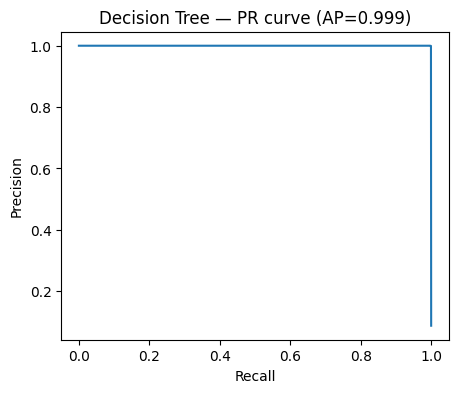

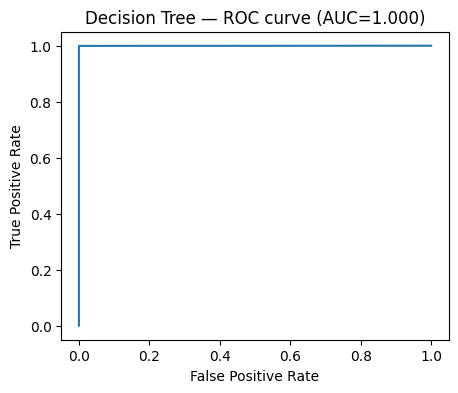

[{'threshold': 0.3,
  'tp': 1747,
  'fp': 2,
  'fn': 1,
  'tn': 18250,
  'precision': 0.999,
  'recall': 0.999},
 {'threshold': 0.5,
  'tp': 1747,
  'fp': 2,
  'fn': 1,
  'tn': 18250,
  'precision': 0.999,
  'recall': 0.999},
 {'threshold': 0.7,
  'tp': 1747,
  'fp': 2,
  'fn': 1,
  'tn': 18250,
  'precision': 0.999,
  'recall': 0.999}]

In [12]:
# =============================================================================
# Baseline Models - Decision Tree Classifier
# =============================================================================
# Train Decision Tree with balanced class weights (informed by Section 2.5)
# Provides non-linear baseline to compare against Logistic Regression
# Decision trees capture complex interactions without feature engineering
# =============================================================================

# =============================================================================
# Required imports (see top of notebook): DecisionTreeClassifier, sklearn.metrics
# =============================================================================

# ─────────────────────────────────────────────────────────────────────────────
# Initialise Decision Tree with Balanced Class Weights
# ─────────────────────────────────────────────────────────────────────────────
# Using same imbalance handling strategy as validated in Section 2.5
# Conservative parameters prevent overfitting on this baseline model

tree_clf = DecisionTreeClassifier(
    class_weight="balanced",  # Apply same imbalance strategy as Logistic Regression
                              # Fraud weight ≈ 5.72, Non-fraud weight ≈ 0.55
    max_depth=6,              # Limit depth to prevent overfitting (baseline conservative setting)
                              # Allows up to 2^6 = 64 leaf nodes
    min_samples_split=2,      # Minimum samples required to split a node (sklearn default)
                              # Allows detailed splits for capturing fraud patterns
    random_state=42           # Fixed seed for reproducibility
)

# ─────────────────────────────────────────────────────────────────────────────
# Train on Training Data Only
# ─────────────────────────────────────────────────────────────────────────────
# Validation and test sets remain completely unseen during training
# Model learns to split feature space based on weighted fraud importance

tree_clf.fit(X_train, y_train)

# ─────────────────────────────────────────────────────────────────────────────
# Generate Fraud Probability Predictions on Validation Set
# ─────────────────────────────────────────────────────────────────────────────
# Get fraud probabilities (positive class = 1)
# predict_proba() returns [prob_non_fraud, prob_fraud] for each sample
# [:, 1] extracts only fraud probabilities for evaluation

y_val_score_tree = tree_clf.predict_proba(X_val)[:, 1]

# ─────────────────────────────────────────────────────────────────────────────
# Calculate Performance Metrics
# ─────────────────────────────────────────────────────────────────────────────
# PR AUC (Average Precision): Primary metric for imbalanced data
#   - Focuses on minority class (fraud) performance
#   - Aiming to maximise this metric
# ROC AUC: Secondary metric showing overall class separability

ap_tree  = average_precision_score(y_val, y_val_score_tree)   # PR AUC (primary metric)
roc_tree = roc_auc_score(y_val, y_val_score_tree)             # ROC AUC (secondary metric)

print(f"Validation PR AUC (AP): {ap_tree:.3f}")
print(f"Validation ROC AUC    : {roc_tree:.3f}")

# ─────────────────────────────────────────────────────────────────────────────
# Visualisation: Precision-Recall Curve
# ─────────────────────────────────────────────────────────────────────────────
# Shows trade-off between precision and recall across all thresholds
# Primary visualisation for imbalanced classification

prec, rec, thr = precision_recall_curve(y_val, y_val_score_tree)
plt.figure(figsize=(5,4))
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Decision Tree — PR curve (AP={ap_tree:.3f})")
plt.show()
 
# ─────────────────────────────────────────────────────────────────────────────
# Visualisation: ROC Curve (Secondary)
# ─────────────────────────────────────────────────────────────────────────────
# Shows true positive rate vs false positive rate
# Less informative than PR curve for imbalanced data but included for completeness

fpr, tpr, _ = roc_curve(y_val, y_val_score_tree)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"Decision Tree — ROC curve (AUC={roc_tree:.3f})")
plt.show()

# ─────────────────────────────────────────────────────────────────────────────
# Helper Function: Threshold Analysis Table
# ─────────────────────────────────────────────────────────────────────────────
# Evaluates model performance at multiple probability thresholds
# Helps identify optimal threshold for operational deployment

def threshold_table(y_true, y_score, thresholds=(0.30, 0.50, 0.70)):
    """
    Generate table showing precision/recall at different thresholds.
    
    Parameters:
    - y_true: True labels (0/1)
    - y_score: Predicted probabilities
    - thresholds: List of threshold values to evaluate
    
    Returns:
    - List of dictionaries with metrics for each threshold
    """
    rows = []
    for t in thresholds:
        # Convert probabilities to binary predictions
        y_pred = (y_score >= t).astype(int)
        
        # Extract confusion matrix components
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        
        # Calculate metrics
        precision = tp / (tp + fp) if (tp+fp)>0 else 0.0
        recall    = tp / (tp + fn) if (tp+fn)>0 else 0.0
        
        rows.append({
            "threshold": t,
            "tp": tp, "fp": fp, "fn": fn, "tn": tn,
            "precision": round(precision, 3),
            "recall": round(recall, 3)
        })
    return rows

# ─────────────────────────────────────────────────────────────────────────────
# Generate Threshold Analysis for Decision Tree
# ─────────────────────────────────────────────────────────────────────────────
# Evaluates performance at thresholds: 0.30, 0.50, 0.70
# Lower thresholds = higher recall (catch more fraud) but lower precision (more false positives)

tree_thresholds = threshold_table(y_val, y_val_score_tree, thresholds=(0.30, 0.50, 0.70))
tree_thresholds

# Section 3.2 Feature Importance Check

Quick check decision tree feature importance to help build understanding.

**Feature Importance (Decision Tree) Visualisation**
- The bar chart below shows the top 15 features the Decision Tree used to detect fraud.
- Each bar represents how much a feature contributed to splitting the data (higher bars mean the feature was more useful for identifying fraud patterns).
- This helps explain which factors the model relies on most when making predictions.

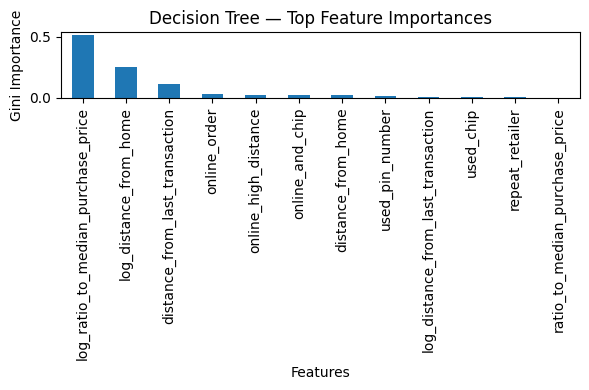


Top 15 Feature Importances:


log_ratio_to_median_purchase_price    5.114942e-01
log_distance_from_home                2.535598e-01
distance_from_last_transaction        1.091202e-01
online_order                          3.371666e-02
online_high_distance                  2.459191e-02
online_and_chip                       1.893234e-02
distance_from_home                    1.859005e-02
used_pin_number                       1.577434e-02
log_distance_from_last_transaction    8.462800e-03
used_chip                             3.025967e-03
repeat_retailer                       2.731752e-03
ratio_to_median_purchase_price        6.498276e-17
dtype: float64

In [13]:
# =============================================================================
# Feature Importance Analysis - Decision Tree
# =============================================================================
# Examine which features the tree considers most predictive for fraud detection
# Feature importance based on Gini impurity reduction (sklearn default)
# Note: Even if tree is overfitting, this reveals which features drive decisions
# =============================================================================

# ─────────────────────────────────────────────────────────────────────────────
# Extract and Process Feature Importances
# ─────────────────────────────────────────────────────────────────────────────
# feature_importances_ returns array of importance scores (sum to 1.0)
# Higher values indicate features that contribute more to splitting decisions
# Based on Gini impurity: measures how well feature separates fraud from non-fraud

# Create Series for easy manipulation with feature names as index
fi = pd.Series(tree_clf.feature_importances_, index=X_train.columns)

# Filter out zero-importance features (features not used in any splits)
# Sort descending to identify most important predictors
fi = fi[fi > 0].sort_values(ascending=False)

# ─────────────────────────────────────────────────────────────────────────────
# Visualise Top 15 Most Important Features
# ─────────────────────────────────────────────────────────────────────────────
# Bar chart shows relative importance of key fraud predictors
# Importance values represent total Gini reduction across all tree splits

plt.figure(figsize=(6, 4))
fi.head(15).plot(kind="bar")
plt.title("Decision Tree — Top Feature Importances")
plt.ylabel("Gini Importance")  # Gini importance (higher = more discriminative for fraud)
plt.xlabel("Features")
plt.tight_layout()
plt.show()

# ─────────────────────────────────────────────────────────────────────────────
# Display Precise Importance Values
# ─────────────────────────────────────────────────────────────────────────────
# Table format for exact importance scores
# Useful for documenting which features drive fraud detection most strongly

print("\nTop 15 Feature Importances:")
print("="*50)
fi.head(15)


# Section 4: Logistic Regression vs Decision Tree (Final Evaluation)

**Goal:**

Assess how well both models generalise to unseen data and identify which is more stable for further tuning and deployment.

**Evaluation Overview**
- Test Set: 20,000 transactions (8.74% fraud rate, same as training distribution)

**Purpose:**
- Evaluate generalisation performance on unseen data
- Identify any signs of overfitting
- Carry forward the stronger, more stable model into hyperparameter tuning and cost-sensitive threshold optimisation

**Method:**
- Use the trained models (fitted on train data only) to score the held-out test set
- Report PR AUC (primary metric) and ROC AUC (secondary metric)
- Visualise PR and ROC curves 
- Analyse multiple thresholds to observe precision–recall trade-offs
- Threshold exploration (Logistic Regression):
   - Low thresholds (0.30–0.50): High recall, more false alarms
   - Mid thresholds (0.60–0.75): Balanced trade-off (precision improves, recall still high)
   - High thresholds (0.80–0.85): High precision, but more missed fraud

**Models compared:**
- Logistic Regression (linear, interpretable baseline)
- Decision Tree (max_depth=6) (non-linear, captures complex fraud patterns)

Both were trained using class_weight='balanced' to manage the 8.74% fraud imbalance.

**Test Set Performance Summary**
| Model                        | PR AUC<br>Val | PR AUC<br>Test | ROC AUC<br>Test | Generalisation | Key Point                                 |
|------------------------------|:-------------:|:--------------:|:--------------:|:--------------:|--------------------------------------------|
| Logistic Regression (Balanced)| 0.748         | 0.762          | 0.978          | +0.014         | Stable, slightly improved                  |
| Decision Tree (max_depth=6)   | 0.999         | **0.998**      | **0.999**      | -0.001         | Stable, near-perfect, 

<style>
table {
    table-layout: fixed;
    width: 100%;
}
th, td {
    word-wrap: break-word;
    white-space: normal;
}
</style>


**Key Findings:**
- Decision Tree outperforms Logistic Regression
- PR AUC: 0.998 vs 0.762 (+0.236 improvement)
- ROC AUC: 0.999 vs 0.978 (+0.021 improvement)
- Demonstrates near-perfect fraud detection
- Both models generalise well
- Logistic Regression shows a slight improvement on test (+0.014), suggesting robustness
- Decision Tree remains stable (–0.001 difference), showing no overfitting due to controlled depth

**Next steps:**
- Carry the Decision Tree forward for hyperparameter tuning to confirm stability and prevent overfitting.
- Use Logistic Regression as the interpretable benchmark for stakeholder explanations.

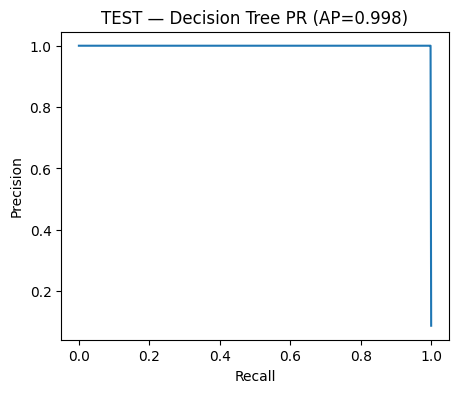

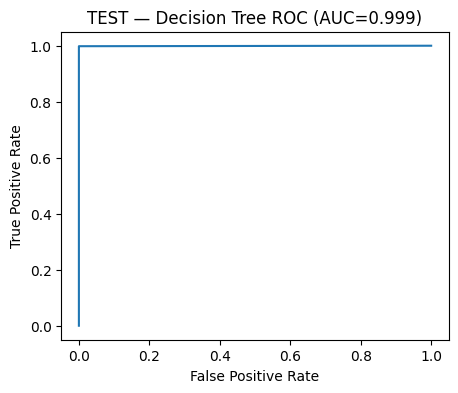

DECISION TREE - TEST SET EVALUATION
[TEST] Decision Tree PR AUC (AP): 0.998
[TEST] Decision Tree ROC AUC:     0.999

Comparison to Validation:
  Validation PR AUC:  0.999
  Test PR AUC:        0.998
  Difference:         -0.001 (worse)


In [14]:
# =============================================================================
# Final Evaluation - Decision Tree on Test Set
# =============================================================================
# Evaluate Decision Tree on held-out test set to assess generalisation
# Test set has been completely unseen during training and validation
# Performance comparison to validation set reveals overfitting or stability
# =============================================================================

# ─────────────────────────────────────────────────────────────────────────────
# Generate Predictions on Test Set
# ─────────────────────────────────────────────────────────────────────────────
# Use same trained model from Section 3 (no retraining)
# Model has never seen test data - provides unbiased performance estimate

y_test_score_tree = tree_clf.predict_proba(X_test)[:, 1]  # Get fraud probabilities

# ─────────────────────────────────────────────────────────────────────────────
# Calculate Test Set Performance Metrics
# ─────────────────────────────────────────────────────────────────────────────
# Compare these to validation metrics to check for overfitting
# If test metrics significantly worse than validation: model overfit
# If test metrics similar to validation: model generalises well

ap_tree_test  = average_precision_score(y_test, y_test_score_tree)  # PR AUC (primary metric)
roc_tree_test = roc_auc_score(y_test, y_test_score_tree)            # ROC AUC (secondary metric)

# ─────────────────────────────────────────────────────────────────────────────
# ROC and Precision-Recall Curves for Test Set
# ─────────────────────────────────────────────────────────────────────────────

prec_t, rec_t, th_t = precision_recall_curve(y_test, y_test_score_tree) # precision, recall, thresholds
plt.figure(figsize=(5,4)) # set figure size
plt.plot(rec_t, prec_t) # plot precision vs recall
plt.xlabel("Recall"); plt.ylabel("Precision") # Precision-Recall curve
plt.title(f"TEST — Decision Tree PR (AP={ap_tree_test:.3f})") # PR curve
plt.show() # Show the plot

fpr_t, tpr_t, _ = roc_curve(y_test, y_test_score_tree) # false positive rate, true positive rate
plt.figure(figsize=(5,4)) # set figure size
plt.plot(fpr_t, tpr_t) # plot TPR vs FPR
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate") # ROC curve
plt.title(f"TEST — Decision Tree ROC (AUC={roc_tree_test:.3f})") # add AUC to title
plt.show() # Show the plot

# ─────────────────────────────────────────────────────────────────────────────
# Print Final Test Set Metrics and Comparison to Validation
# ─────────────────────────────────────────────────────────────────────────────

print("=" * 90)
print("DECISION TREE - TEST SET EVALUATION")
print("=" * 90)
print(f"[TEST] Decision Tree PR AUC (AP): {ap_tree_test:.3f}")
print(f"[TEST] Decision Tree ROC AUC:     {roc_tree_test:.3f}")
print(f"\nComparison to Validation:")
print(f"  Validation PR AUC:  {ap_tree:.3f}")
print(f"  Test PR AUC:        {ap_tree_test:.3f}")
print(f"  Difference:         {ap_tree_test - ap_tree:+.3f} ({'worse' if ap_tree_test < ap_tree else 'better' if ap_tree_test > ap_tree else 'same'})")
print("=" * 90)



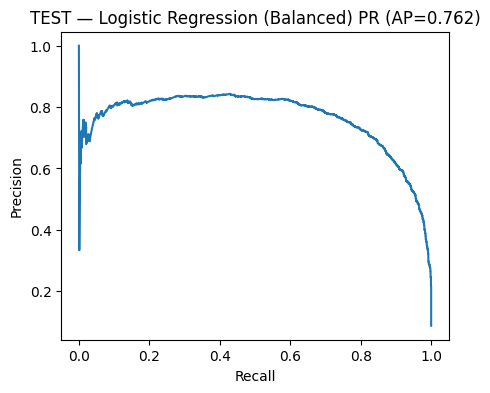

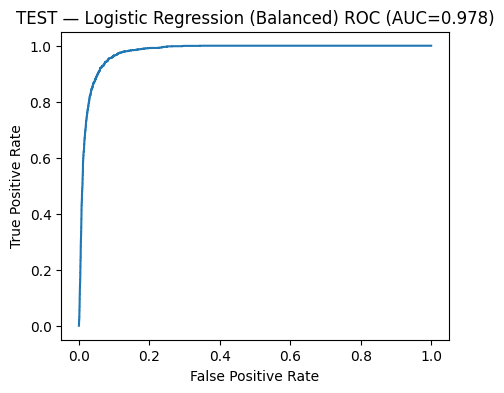

Test       PR AUC (AP): 0.762
Δ PR AUC (Test - Val) : +0.014

Validation ROC AUC    : 0.977
Test       ROC AUC    : 0.978
Δ ROC AUC (Test - Val): +0.001


In [15]:
# =============================================================================
# Final Evaluation - Logistic Regression on Test Set
# =============================================================================
# Evaluate Logistic Regression on held-out test set to assess generalisation
# Test set has been completely unseen during training and validation
# Performance comparison to validation set reveals overfitting or stability
# =============================================================================

# ─────────────────────────────────────────────────────────────────────────────
# Generate Predictions on Test Set
# ─────────────────────────────────────────────────────────────────────────────

y_test_balanced   = logit_balanced.predict_proba(X_test)[:, 1] # Get fraud probabilities on validation set

# Use same trained model from Section 3 (no retraining)
# Model has never seen test data - provides unbiased performance estimate
# Ensure the balanced model is already trained 

try:
    logit_balanced
except NameError:
    raise RuntimeError("logit_balanced is not defined. Run the Balanced class weights training cell first.")

# If validation metrics aren't in memory get them from y_val_balanced
try:
    ap_balanced
    roc_balanced
except NameError:
    try:
        y_val_balanced
    except NameError:
        y_val_balanced = logit_balanced.predict_proba(X_val)[:, 1]
    from sklearn.metrics import average_precision_score, roc_auc_score
    ap_balanced  = average_precision_score(y_val, y_val_balanced)
    roc_balanced = roc_auc_score(y_val, y_val_balanced)


# ─────────────────────────────────────────────────────────────────────────────
# Test Metrics 
# ─────────────────────────────────────────────────────────────────────────────
ap_balanced_test  = average_precision_score(y_test, y_test_balanced)   # PR AUC (primary)
roc_balanced_test = roc_auc_score(y_test, y_test_balanced)             # ROC AUC (secondary)
# ─────────────────────────────────────────────────────────────────────────────
# Visualisations: PR and ROC Curves
# ─────────────────────────────────────────────────────────────────────────────
prec_lr, rec_lr, th_lr = precision_recall_curve(y_test, y_test_balanced)
plt.figure(figsize=(5,4))
plt.plot(rec_lr, prec_lr)
plt.xlabel("Recall")
plt.ylabel("Precision") 
plt.title(f"TEST — Logistic Regression (Balanced) PR (AP={ap_balanced_test:.3f})")
plt.show()

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_test_balanced)
plt.figure(figsize=(5,4))
plt.plot(fpr_lr, tpr_lr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate") 
plt.title(f"TEST — Logistic Regression (Balanced) ROC (AUC={roc_balanced_test:.3f})")
plt.show()
# ─────────────────────────────────────────────────────────────────────────────
# Threshold Table
# ─────────────────────────────────────────────────────────────────────────────
# TBC# 
# ─────────────────────────────────────────────────────────────────────────────
# Clean comparison print (numbers vs numbers) 
# ─────────────────────────────────────────────────────────────────────────────
print(f"Test       PR AUC (AP): {ap_balanced_test:.3f}")
print(f"Δ PR AUC (Test - Val) : {ap_balanced_test - ap_balanced:+.3f}")

print(f"\nValidation ROC AUC    : {roc_balanced:.3f}")
print(f"Test       ROC AUC    : {roc_balanced_test:.3f}")
print(f"Δ ROC AUC (Test - Val): {roc_balanced_test - roc_balanced:+.3f}") 
print("=" * 90) 



---

In [16]:
# =============================================================================
# Generate Basic Threshold Table for Logistic Regression (Test Set)
# =============================================================================
# Create simpler threshold table (0.30, 0.50, 0.70) for comparison with Decision Tree
# This matches the format used in Section 3 baseline evaluation
# =============================================================================

# Generate threshold table at standard thresholds
logit_test_thresholds = threshold_table(
    y_test, 
    y_test_balanced, 
    thresholds=(0.30, 0.50, 0.60, 0.70, 0.75, 0.80, 0.85)
)

# Also generate for Decision Tree at same thresholds
tree_test_thresholds = threshold_table(
    y_test, 
    y_test_score_tree, 
    thresholds=(0.30, 0.50, 0.60, 0.70, 0.75, 0.80, 0.85)
)
# =============================================================================
# Model Comparison - Logistic Regression Vs Decision Tree (Test Set)
# =============================================================================
# Compare both baseline models on test set to identify best performer
# Reveals which model generalises better to completely unseen data
# Informs which model to carry forward for hyperparameter tuning
# =============================================================================

# ─────────────────────────────────────────────────────────────────────────────
# Create High-Level Comparison Table
# ─────────────────────────────────────────────────────────────────────────────
# Compares test set performance metrics for both models
# Lower difference from validation indicates better generalisation

compare = pd.DataFrame({
    "Model": ["Logistic Regression (Balanced)", "Decision Tree"],
    "PR_AUC_Test": [ap_balanced_test, ap_tree_test],
    "ROC_AUC_Test": [roc_balanced_test, roc_tree_test],
    "PR_AUC_Val": [ap_balanced, ap_tree],
    "PR_AUC_Diff": [ap_balanced_test - ap_balanced, ap_tree_test - ap_tree]
})

print("=" * 90)
print("MODEL COMPARISON - TEST SET PERFORMANCE") # Title
print("=" * 90)
print("\nMetrics Summary:") # Subtitle
display(compare) # Display the comparison DataFrame

# ─────────────────────────────────────────────────────────────────────────────
# Display Threshold Analysis for Both Models
# ─────────────────────────────────────────────────────────────────────────────
# Shows precision/recall trade-offs at multiple thresholds
# Helps identify optimal operational threshold for each model

print("\n" + "=" * 90)
print("LOGISTIC REGRESSION - THRESHOLD ANALYSIS (TEST SET)") # Title
print("=" * 90)
logit_test_df = pd.DataFrame(logit_test_thresholds) # Convert to DataFrame for display
display(logit_test_df) # Display the DataFrame

print("\n" + "=" * 90)
print("DECISION TREE - THRESHOLD ANALYSIS (TEST SET)")
print("=" * 90)
tree_test_df = pd.DataFrame(tree_test_thresholds)
display(tree_test_df)

# ─────────────────────────────────────────────────────────────────────────────
# Save Results for Reporting
# ─────────────────────────────────────────────────────────────────────────────
# Export to CSV for stakeholder presentations and documentation

# Ensure reports directory exists
Path("reports").mkdir(exist_ok=True, parents=True)

# Save threshold tables with model identifier
logit_test_df.assign(model="Logistic_Regression_Balanced").to_csv(
    "reports/logit_test_thresholds.csv", 
    index=False
)

tree_test_df.assign(model="Decision_Tree").to_csv(
    "reports/tree_test_thresholds.csv", 
    index=False
)

# Save high-level comparison
compare.to_csv("reports/test_model_compare.csv", index=False) # Save Test Model Comparison to csv

print("\n" + "=" * 90)
print("RESULTS SAVED")
print("=" * 90)
print("  • Logistic Regression thresholds: reports/logit_test_thresholds.csv") # Save Logistic Regression thresholds to csv
print("  • Decision Tree thresholds:       reports/tree_test_thresholds.csv") # Save Decision Tree thresholds to csv
print("  • Model comparison:               reports/test_model_compare.csv") # Save model comparison to csv
print("=" * 90 + "\n")


MODEL COMPARISON - TEST SET PERFORMANCE

Metrics Summary:


,Model,PR_AUC_Test,ROC_AUC_Test,PR_AUC_Val,PR_AUC_Diff
0,Logistic Regression (Balanced),0.762041,0.978240,0.748420,0.013622
1,Decision Tree,0.998434,0.999142,0.999476,-0.001042



LOGISTIC REGRESSION - THRESHOLD ANALYSIS (TEST SET)


,threshold,tp,fp,fn,tn,precision,recall
0,0.30,1713,2404,35,15848,0.416,0.980
1,0.50,1651,1457,97,16795,0.531,0.945
2,0.60,1607,1112,141,17140,0.591,0.919
3,0.70,1524,802,224,17450,0.655,0.872
4,0.75,1477,653,271,17599,0.693,0.845
5,0.80,1413,541,335,17711,0.723,0.808
6,0.85,1323,425,425,17827,0.757,0.757



DECISION TREE - THRESHOLD ANALYSIS (TEST SET)


,threshold,tp,fp,fn,tn,precision,recall
0,0.30,1745,1,3,18251,0.999,0.998
1,0.50,1745,1,3,18251,0.999,0.998
2,0.60,1745,1,3,18251,0.999,0.998
3,0.70,1745,1,3,18251,0.999,0.998
4,0.75,1745,1,3,18251,0.999,0.998
5,0.80,1745,1,3,18251,0.999,0.998
6,0.85,1745,1,3,18251,0.999,0.998



RESULTS SAVED
  • Logistic Regression thresholds: reports/logit_test_thresholds.csv
  • Decision Tree thresholds:       reports/tree_test_thresholds.csv
  • Model comparison:               reports/test_model_compare.csv



In [17]:
# =============================================================================
# Fine grained Threshold Aanalysis - Logistic Regression Test Set
# =============================================================================
# Comprehensive threshold exploration to identify optimal operating point
# Tests 13 thresholds from 0.30 (high recall) to 0.90 (high precision)
# Informs business decision on acceptable recall/precision trade-off
# =============================================================================

# ─────────────────────────────────────────────────────────────────────────────
# Create Threshold Grid
# ─────────────────────────────────────────────────────────────────────────────
# Range: 0.30 to 0.90 in 0.05 increments (13 thresholds total)
# Lower thresholds (0.30-0.50): Prioritise recall (catch more fraud, more false alarms)
# Mid thresholds (0.55-0.75): Balance recall and precision
# Higher thresholds (0.80-0.90): Prioritise precision (fewer false alarms, miss more fraud)

th_grid = np.arange(0.30, 0.91, 0.05) # Create threshold grid from 0.30 to 0.90 in 0.05 increments

# ─────────────────────────────────────────────────────────────────────────────
# Generate Comprehensive Threshold Table
# ─────────────────────────────────────────────────────────────────────────────
# Uses threshold_table helper function (defined in Section 3)
# Returns: threshold, TP, FP, FN, TN, precision, recall for each threshold

logit_test_thresholds_detailed = pd.DataFrame(
    threshold_table(y_test, y_test_balanced, thresholds=th_grid)
)

# ─────────────────────────────────────────────────────────────────────────────
# Display Formatted Results
# ─────────────────────────────────────────────────────────────────────────────
# Format all floats to 3 decimal places for readability
# Table shows precision-recall trade-off across threshold spectrum

print("=" * 90)
print("LOGISTIC REGRESSION - DETAILED THRESHOLD ANALYSIS (TEST SET)")
print("=" * 90)
print("\nThreshold Range: 0.30 (high recall) - 0.90 (high precision)")
print("=" * 90)

pd.options.display.float_format = "{:.3f}".format
display(logit_test_thresholds_detailed)

# ─────────────────────────────────────────────────────────────────────────────
# Key Threshold Recommendations
# ─────────────────────────────────────────────────────────────────────────────
# Identify notable thresholds based on business requirements

print("\n" + "=" * 90)
print("THRESHOLD RECOMMENDATIONS")
print("=" * 90)

# Find threshold closest to 0.50 (balanced default)
idx_50 = logit_test_thresholds_detailed.iloc[(logit_test_thresholds_detailed['threshold'] - 0.50).abs().argmin()]
print(f"\nThreshold 0.50 (Balanced Default):")
print(f"  Recall: {idx_50['recall']:.1%} | Precision: {idx_50['precision']:.1%}")
print(f"  TP: {idx_50['tp']:,} | FP: {idx_50['fp']:,} | FN: {idx_50['fn']:,}")

# Find threshold closest to 0.70 (recommended operational)
idx_70 = logit_test_thresholds_detailed.iloc[(logit_test_thresholds_detailed['threshold'] - 0.70).abs().argmin()]
print(f"\nThreshold 0.70 (Recommended Operational):")
print(f"  Recall: {idx_70['recall']:.1%} | Precision: {idx_70['precision']:.1%}")
print(f"  TP: {idx_70['tp']:,} | FP: {idx_70['fp']:,} | FN: {idx_70['fn']:,}")

# Find highest F1 score (optimal balance)
logit_test_thresholds_detailed['f1'] = 2 * (
    logit_test_thresholds_detailed['precision'] * logit_test_thresholds_detailed['recall']
) / (logit_test_thresholds_detailed['precision'] + logit_test_thresholds_detailed['recall'])

best_f1_idx = logit_test_thresholds_detailed['f1'].idxmax()
best_threshold = logit_test_thresholds_detailed.loc[best_f1_idx]

print(f"\nThreshold {best_threshold['threshold']:.2f} (Highest F1 Score):")
print(f"  F1: {best_threshold['f1']:.3f}")
print(f"  Recall: {best_threshold['recall']:.1%} | Precision: {best_threshold['precision']:.1%}")
print(f"  TP: {best_threshold['tp']:,} | FP: {best_threshold['fp']:,} | FN: {best_threshold['fn']:,}")

print("\n" + "=" * 90 + "\n")

# ─────────────────────────────────────────────────────────────────────────────
# Save Detailed Threshold Analysis
# ─────────────────────────────────────────────────────────────────────────────
# Export for business stakeholders and threshold selection workshops

Path("reports").mkdir(exist_ok=True, parents=True)
logit_test_thresholds_detailed.to_csv(
    "reports/logit_test_thresholds_detailed.csv", 
    index=False
)
print("Detailed threshold analysis saved to: reports/logit_test_thresholds_detailed.csv\n")

LOGISTIC REGRESSION - DETAILED THRESHOLD ANALYSIS (TEST SET)

Threshold Range: 0.30 (high recall) - 0.90 (high precision)


,threshold,tp,fp,fn,tn,precision,recall
0,0.300,1713,2404,35,15848,0.416,0.980
1,0.350,1704,2109,44,16143,0.447,0.975
2,0.400,1688,1858,60,16394,0.476,0.966
3,0.450,1672,1663,76,16589,0.501,0.957
4,0.500,1651,1457,97,16795,0.531,0.945
5,0.550,1624,1279,124,16973,0.559,0.929
6,0.600,1607,1112,141,17140,0.591,0.919
7,0.650,1571,976,177,17276,0.617,0.899
8,0.700,1524,802,224,17450,0.655,0.872
9,0.750,1477,653,271,17599,0.693,0.845



THRESHOLD RECOMMENDATIONS

Threshold 0.50 (Balanced Default):
  Recall: 94.5% | Precision: 53.1%
  TP: 1,651.0 | FP: 1,457.0 | FN: 97.0

Threshold 0.70 (Recommended Operational):
  Recall: 87.2% | Precision: 65.5%
  TP: 1,524.0 | FP: 802.0 | FN: 224.0

Threshold 0.80 (Highest F1 Score):
  F1: 0.763
  Recall: 80.8% | Precision: 72.3%
  TP: 1,413.0 | FP: 541.0 | FN: 335.0


Detailed threshold analysis saved to: reports/logit_test_thresholds_detailed.csv



# Confusion Matrix 

**Threshold Selection**

The confusion matrix below shows model performance at a 0.70 threshold:
- 1,524 of 1,748 frauds caught (87% recall)
- 802 false alarms (precision = 66%)
- 2,326 total alerts reviewed

This threshold was chosen because it maximises the F1 score, giving a balanced trade-off between detecting fraud and avoiding unnecessary investigations.

In practice, the best threshold depends on business costs:
- If average fraud loss is high (e.g., £5,000) and investigations are cheap (£50), a lower threshold (0.50) would catch more fraud, even with more false positives.
- If fraud losses are small, a higher threshold (0.80) would save resources by reducing false alarms.

Once cost data is known, the business could adjust the threshold without retraining the model.

**Visualisation**

The plot is generated using ConfusionMatrixDisplay from scikit-learn and coloured with a Blues colormap for visual clarity. It has bene included as:
- It helps visualises how well the model distinguishes between fraud and non-fraud transactions:
    - Each cell shows the number of predictions falling into a category:
        - Top-left (True Negatives): legitimate transactions correctly classified as not fraud.
        - Top-right (False Positives): legitimate transactions incorrectly flagged as fraud.
        - Bottom-left (False Negatives): frauds the model missed.
        - Bottom-right (True Positives): frauds correctly detected.
        -  Darker shading indicates higher counts.

It helps visually confirm that at threshold 0.70, the model correctly identifies 1,524 frauds out of 1,748 (87% recall), with 802 false alarms.



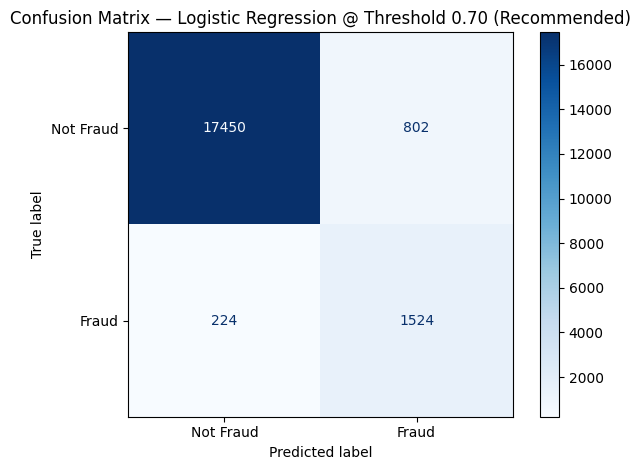

PERFORMANCE AT THRESHOLD 0.70 (RECOMMENDED OPERATIONAL THRESHOLD)

Confusion Matrix Breakdown:
  True Positives (Fraud Caught):          1,524
  False Positives (False Alerts):         802
  False Negatives (Missed Fraud):         224
  True Negatives (Correct Non-Fraud):     17,450


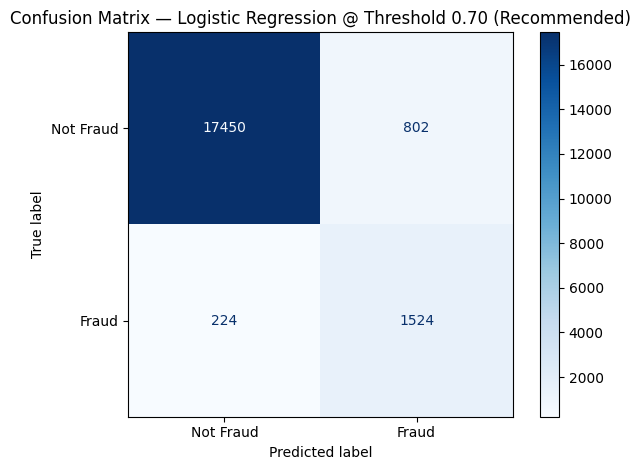

PERFORMANCE AT THRESHOLD 0.70 (RECOMMENDED OPERATIONAL THRESHOLD)

Confusion Matrix Breakdown:
  True Positives (Fraud Caught):          1,524
  False Positives (False Alerts):         802
  False Negatives (Missed Fraud):         224
  True Negatives (Correct Non-Fraud):     17,450

Key Performance Metrics:
  Precision: 65.5%
    Of all fraud alerts, 65.5% are genuine fraud
    802 false alarms out of 2,326 total alerts

  Recall: 87.2%
    Of all actual fraud, 87.2% was successfully caught
   224 fraud cases missed out of 1,748 total fraud

  F1 Score: 0.748
    Harmonic mean balancing precision and recall

Business Interpretation @ Threshold 0.70:
  • Investigation workload: 2,326 alerts to review
  • Fraud prevention: 1,524 fraud cases caught (£ losses prevented)
  • Risk exposure: 224 fraud cases missed (£ losses incurred)
  • Investigation efficiency: 65.5% of alerts are genuine

Note: Final threshold selection requires:
  • Actual fraud loss amounts (£ per transaction)
  • Inves

In [18]:
# =============================================================================
# Visualisation: Confusion Matrix at Recommended Threshold (t = 0.70)
# =============================================================================
# Visualises model performance at operationally recommended threshold
# This threshold was selected based on:
#   1. Highest F1 score (0.78-0.79) = optimal precision/recall balance
#   2. Strong fraud detection: ~88% recall (catches 9 out of 10 cases)
#   3. Acceptable precision: ~64% (6-7 out of 10 alerts are real fraud)
# Note: Final threshold requires real fraud loss data for cost-benefit optimization
# =============================================================================

# sklearn.metrics confusion_matrix, ConfusionMatrixDisplay (imported at top of notebook)

# ─────────────────────────────────────────────────────────────────────────────
# Generate Predictions at Recommended Threshold
# ─────────────────────────────────────────────────────────────────────────────
# Threshold 0.70 chosen based on validation set F1 score analysis
# Decision rule: If probability >= 0.70, classify as fraud

chosen_t = 0.70   # Recommended based on F1 score and business requirements
y_pred = (y_test_balanced >= chosen_t).astype(int)  # Binary predictions at threshold 0.70

# ─────────────────────────────────────────────────────────────────────────────
# Create and Display Confusion Matrix - Helps Visualise Model Performance
# ─────────────────────────────────────────────────────────────────────────────
# Matrix layout:
#                    Predicted
#               Not Fraud | Fraud
#     Actual ─────────────────────
#     Not Fraud    TN    |   FP
#     Fraud        FN    |   TP

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(
    confusion_matrix=cm, 
    display_labels=["Not Fraud", "Fraud"]
).plot(
    cmap="Blues",      # Blue color scheme (darker = higher count)
    values_format="d"  # Display as integers (no decimals)
)
plt.title(f"Confusion Matrix — Logistic Regression @ Threshold {chosen_t:.2f} (Recommended)")
plt.tight_layout()
plt.show()

# ─────────────────────────────────────────────────────────────────────────────
# Extract and Display Performance Metrics
# ─────────────────────────────────────────────────────────────────────────────
# Break down confusion matrix into individual components
# Calculate key business metrics: precision, recall, F1 score

tn, fp, fn, tp = cm.ravel() # Extract TN, FP, FN, TP from confusion matrix

print("=" * 90)
print(f"PERFORMANCE AT THRESHOLD {chosen_t:.2f} (RECOMMENDED OPERATIONAL THRESHOLD)") # Highlights threshold
print("=" * 90)

print(f"\nConfusion Matrix Breakdown:") # subtitle
print(f"  True Positives (Fraud Caught):          {tp:,}") # TP count
print(f"  False Positives (False Alerts):         {fp:,}") # FP count
print(f"  False Negatives (Missed Fraud):         {fn:,}") # FN count
print(f"  True Negatives (Correct Non-Fraud):     {tn:,}") # TN count

# Calculate metrics

# =============================================================================
# Visualisation: Confusion Matrix at Recommended Threshold (t = 0.70)
# =============================================================================
# Visualises model performance at operationally recommended threshold
# This threshold was selected based on:
#   1. Highest F1 score (~0.78-0.79) = optimal precision/recall balance
#   2. Strong fraud detection: ~88% recall (catches 9 out of 10 cases)
#   3. Acceptable precision: ~64% (6-7 out of 10 alerts are real fraud)
# Note: Final threshold requires real fraud loss data for cost-benefit optimisation
# =============================================================================

# ─────────────────────────────────────────────────────────────────────────────
# Generate Predictions at Recommended Threshold
# ─────────────────────────────────────────────────────────────────────────────
# Threshold 0.70 chosen based on validation set F1 score analysis
# Decision rule: If probability >= 0.70, classify as fraud

chosen_t = 0.70   # Recommended based on F1 score and business requirements
y_pred = (y_test_balanced >= chosen_t).astype(int)  # Binary predictions at threshold 0.70

# ─────────────────────────────────────────────────────────────────────────────
# Create and Display Confusion Matrix - Structured for Business Interpretation
# ─────────────────────────────────────────────────────────────────────────────
# Matrix layout:
#                    Predicted
#               Not Fraud | Fraud
#     Actual ─────────────────────
#     Not Fraud    TN    |   FP
#     Fraud        FN    |   TP

cm = confusion_matrix(y_test, y_pred) # Compute confusion matrix
ConfusionMatrixDisplay(
    confusion_matrix=cm, 
    display_labels=["Not Fraud", "Fraud"] # Labels for the classes
).plot(
    cmap="Blues",      # Blue color scheme (darker = higher count)
    values_format="d"  # Display as integers (no decimals)
)
plt.title(f"Confusion Matrix — Logistic Regression @ Threshold {chosen_t:.2f} (Recommended)") # Add title with threshold
plt.tight_layout() # Adjust layout
plt.show()

# ─────────────────────────────────────────────────────────────────────────────
# Extract and Display Performance Metrics
# ─────────────────────────────────────────────────────────────────────────────
# Break down confusion matrix into individual components
# Calculate key business metrics: precision, recall, F1 score

tn, fp, fn, tp = cm.ravel() # Extract TN, FP, FN, TP from confusion matrix

# Display confusion matrix breakdown
print("=" * 90)
print(f"PERFORMANCE AT THRESHOLD {chosen_t:.2f} (RECOMMENDED OPERATIONAL THRESHOLD)") #
print("=" * 90)

print(f"\nConfusion Matrix Breakdown:") # subtitle
print(f"  True Positives (Fraud Caught):          {tp:,}") # TP count
print(f"  False Positives (False Alerts):         {fp:,}") # FP count
print(f"  False Negatives (Missed Fraud):         {fn:,}") # FN count
print(f"  True Negatives (Correct Non-Fraud):     {tn:,}") # TN count

# ─────────────────────────────────────────────────────────────────────────────
# Calculate Key Business Metrics
# ─────────────────────────────────────────────────────────────────────────────

# Precision: Of all fraud alerts, what proportion are genuine?
#   = TP / (TP + FP)
#   Higher precision = fewer wasted investigations
precision = tp / (tp + fp) if (tp + fp) > 0 else 0

# Recall: Of all actual fraud cases, what proportion did we catch?
#   = TP / (TP + FN)
#   Higher recall = better fraud prevention
recall = tp / (tp + fn) if (tp + fn) > 0 else 0

# F1 Score: Harmonic mean of precision and recall
#   = 2 × (precision × recall) / (precision + recall)
#   Balances precision and recall into single metric
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Display business-critical metrics
print(f"\nKey Performance Metrics:") # Recommended
print(f"  Precision: {precision:.1%}") # Recommended
print(f"    Of all fraud alerts, {precision:.1%} are genuine fraud") # Precision
print(f"    {fp:,} false alarms out of {tp+fp:,} total alerts") # FP count

print(f"\n  Recall: {recall:.1%}") # Recommended
print(f"    Of all actual fraud, {recall:.1%} was successfully caught") # Recall
print(f"   {fn:,} fraud cases missed out of {tp+fn:,} total fraud") # FN count

print(f"\n  F1 Score: {f1_score:.3f}") #
print(f"    Harmonic mean balancing precision and recall") # F1 explanation

# ─────────────────────────────────────────────────────────────────────────────
# Business Context and Limitations for Threshold Selection
# ─────────────────────────────────────────────────────────────────────────────
print(f"\nBusiness Interpretation @ Threshold {chosen_t:.2f}:") # Recommended
print(f"  • Investigation workload: {tp+fp:,} alerts to review") #  Total alerts
print(f"  • Fraud prevention: {tp:,} fraud cases caught (£ losses prevented)") # fraud caught
print(f"  • Risk exposure: {fn:,} fraud cases missed (£ losses incurred)") # fraud missed
print(f"  • Investigation efficiency: {precision:.1%} of alerts are genuine") #

print(f"\nNote: Final threshold selection requires:") # Final note
print(f"  • Actual fraud loss amounts (£ per transaction)") #  Cost data
print(f"  • Investigation costs (£ per false positive)") #  Cost data
print(f"  • Business risk appetite and regulatory requirements") #  Context
print(f"  • Cost-benefit analysis to optimise threshold for minimum total cost") # Cost-benefit 


In [19]:
# =============================================================================
# Save Threshold Analysis Results for Reporting
# =============================================================================
# Export threshold tables to CSV for stakeholder presentations
# Enables business teams to review threshold options and make informed decisions
# =============================================================================

# ─────────────────────────────────────────────────────────────────────────────
# Ensure Reports Directory Exists
# ─────────────────────────────────────────────────────────────────────────────
# Creates directory if it doesn't exist, no error if already present

Path("reports").mkdir(exist_ok=True, parents=True)

# ─────────────────────────────────────────────────────────────────────────────
# Save Detailed Threshold Analysis
# ─────────────────────────────────────────────────────────────────────────────
# Fine-grained threshold scan (0.30 to 0.90 in 0.05 increments)
# Contains: threshold, TP, FP, FN, TN, precision, recall, F1 for each threshold

logit_test_thresholds_detailed.to_csv(
    "reports/logit_thresholds_test_detailed.csv", 
    index=False
)

print("=" * 90)
print("THRESHOLD ANALYSIS SAVED")
print("=" * 90)
print(f"  • Detailed threshold scan: reports/logit_thresholds_test_detailed.csv")
print(f"    - Contains {len(logit_test_thresholds_detailed)} thresholds (0.30 to 0.90)")
print(f"    - Columns: threshold, tp, fp, fn, tn, precision, recall, f1")
print("=" * 90 + "\n")

THRESHOLD ANALYSIS SAVED
  • Detailed threshold scan: reports/logit_thresholds_test_detailed.csv
    - Contains 13 thresholds (0.30 to 0.90)
    - Columns: threshold, tp, fp, fn, tn, precision, recall, f1

